<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/366_Correlation_Analysis_Part_2_Partial_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation Analysis: Understanding Relationships in Data - Part 2
**Part 8 of the Statistical Analysis in Python Tutorial Series**

## Overview

Correlation analysis is one of the most fundamental and widely-used statistical techniques for exploring relationships between variables. This comprehensive tutorial takes you from basic concepts to advanced applications using real-world penguin morphology data.

---


## Dataset: Palmer Penguins

We'll use the famous Palmer Penguins dataset, which provides:
- **344 penguins** across 3 species (Adelie, Chinstrap, Gentoo)
- **Morphological measurements**: bill length/depth, flipper length, body mass
- **Real biological relationships** to explore and interpret
- **Natural confounding factors** (species effects) to understand


---

## Tutorial Structure

**Part 1: Foundation**
- Data exploration and quality assessment
- Visual demonstration of correlation concepts
- Basic Pearson correlation calculations
- Systematic testing of correlation assumptions
- Diagnostic plotting and interpretation
- Spearman correlation as robust alternative

**Part 2: Partial Correlations**  
- Partial correlations controlling for confounding
- Correlation matrices and multiple relationships
- Visualizing correlations

**Part 3: Advanced Correlation Analysis**
- Confidence Intervals
- Statistical Significance

**Part 4: Correlation vs. causation**
- Correlation vs. causation analysis
- Spurious correlation examples

---



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau
import statsmodels.api as sm
from statsmodels.stats.correlation_tools import corr_nearest, corr_clipped
import warnings
from itertools import combinations
import requests
from io import StringIO

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
import math




# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style consistent with previous tutorials
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [ ]:
# Load palmer penguin dataset from online source
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"

penguins = pd.read_csv(url)


# Display basic information about the dataset
print("\nDataset Information:")
print("=" * 25)
print(f"Shape: {penguins.shape}")
print(f"Columns: {list(penguins.columns)}")


Dataset Information:
Shape: (344, 7)
Columns: ['species', 'island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


In [ ]:
# Check for missing values
print("\nMissing values per column:")
missing_counts = penguins.isnull().sum()
for col, count in missing_counts.items():
    print(f"  {col}: {count}")

# Remove rows with missing values for correlation analysis
penguins_clean = penguins.dropna()
print(f"\nAfter removing missing values: {penguins_clean.shape[0]} complete observations")


Missing values per column:
  species: 0
  island: 0
  bill_length_mm: 2
  bill_depth_mm: 2
  flipper_length_mm: 2
  body_mass_g: 2
  sex: 11

After removing missing values: 333 complete observations


In [ ]:
# Define continuous variables for correlation analysis
continuous_vars = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_vars = ['species', 'island', 'sex']



# 1. Introduction to Correlation Analysis

## What is Correlation?

Correlation measures the strength and direction of a linear relationship between two continuous variables.
It helps us understand how variables move together:

- **Positive correlation**: As one variable increases, the other tends to increase
- **Negative correlation**: As one variable increases, the other tends to decrease
- **Zero correlation**: No linear relationship between variables

## Key Properties of Correlation:

1. **Range**: Correlation coefficients typically range from -1 to +1
2. **Magnitude**: |r| indicates strength of relationship
3. **Sign**: + or - indicates direction of relationship
4. **No causation**: Correlation does not imply causation

## Interpretation Guidelines:
- |r| ≥ 0.7: Strong relationship
- 0.3 ≤ |r| < 0.7: Moderate relationship
- |r| < 0.3: Weak relationship

Let's start by exploring our penguin data to understand the relationships between physical measurements.


# Exploratory Data Analysis for Correlation Studies

## Why EDA Before Correlation Analysis?

Understanding data characteristics determines which correlation methods to use and how to interpret results.

---

## What This Analysis Checks

### 1. **Normality Assessment**
- **Normal data**: Use Pearson correlation
- **Non-normal data**: Use Spearman correlation
- **Tools**: Shapiro-Wilk test, Q-Q plots, histograms

### 2. **Outlier Detection**
- **Impact**: Outliers can distort correlation coefficients
- **Methods**: Box plots, IQR method
- **Decision**: Remove, transform, or use robust methods

### 3. **Species Differences**
- **Large differences**: Species likely confounds correlations
- **Small differences**: Correlations more likely genuine
- **Implication**: Determines need for partial correlation analysis

### 4. **Data Quality**
- **Coefficient of variation**: Measurement reliability
- **Distribution patterns**: Data transformation needs

---

## Key Decisions This EDA Will Guide

**Correlation Method**:
- Normal data → Pearson correlation
- Non-normal data → Spearman correlation

**Analysis Approach**:
- Large species effects → Use partial correlations
- Few outliers → Standard analysis
- Many outliers → Robust methods

This foundation ensures our correlation analysis uses appropriate methods and produces reliable results.


EXPLORATORY DATA ANALYSIS FOR CORRELATION

Descriptive Statistics for Continuous Variables:
--------------------------------------------------
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count          333.00         333.00             333.00       333.00
mean            43.99          17.16             200.97      4207.06
std              5.47           1.97              14.02       805.22
min             32.10          13.10             172.00      2700.00
25%             39.50          15.60             190.00      3550.00
50%             44.50          17.30             197.00      4050.00
75%             48.60          18.70             213.00      4775.00
max             59.60          21.50             231.00      6300.00

Coefficient of Variation (CV = std/mean):
----------------------------------------
bill_length_mm      :   12.4%
bill_depth_mm       :   11.5%
flipper_length_mm   :    7.0%
body_mass_g         :   19.1%

Normality Assessment (Shapiro-

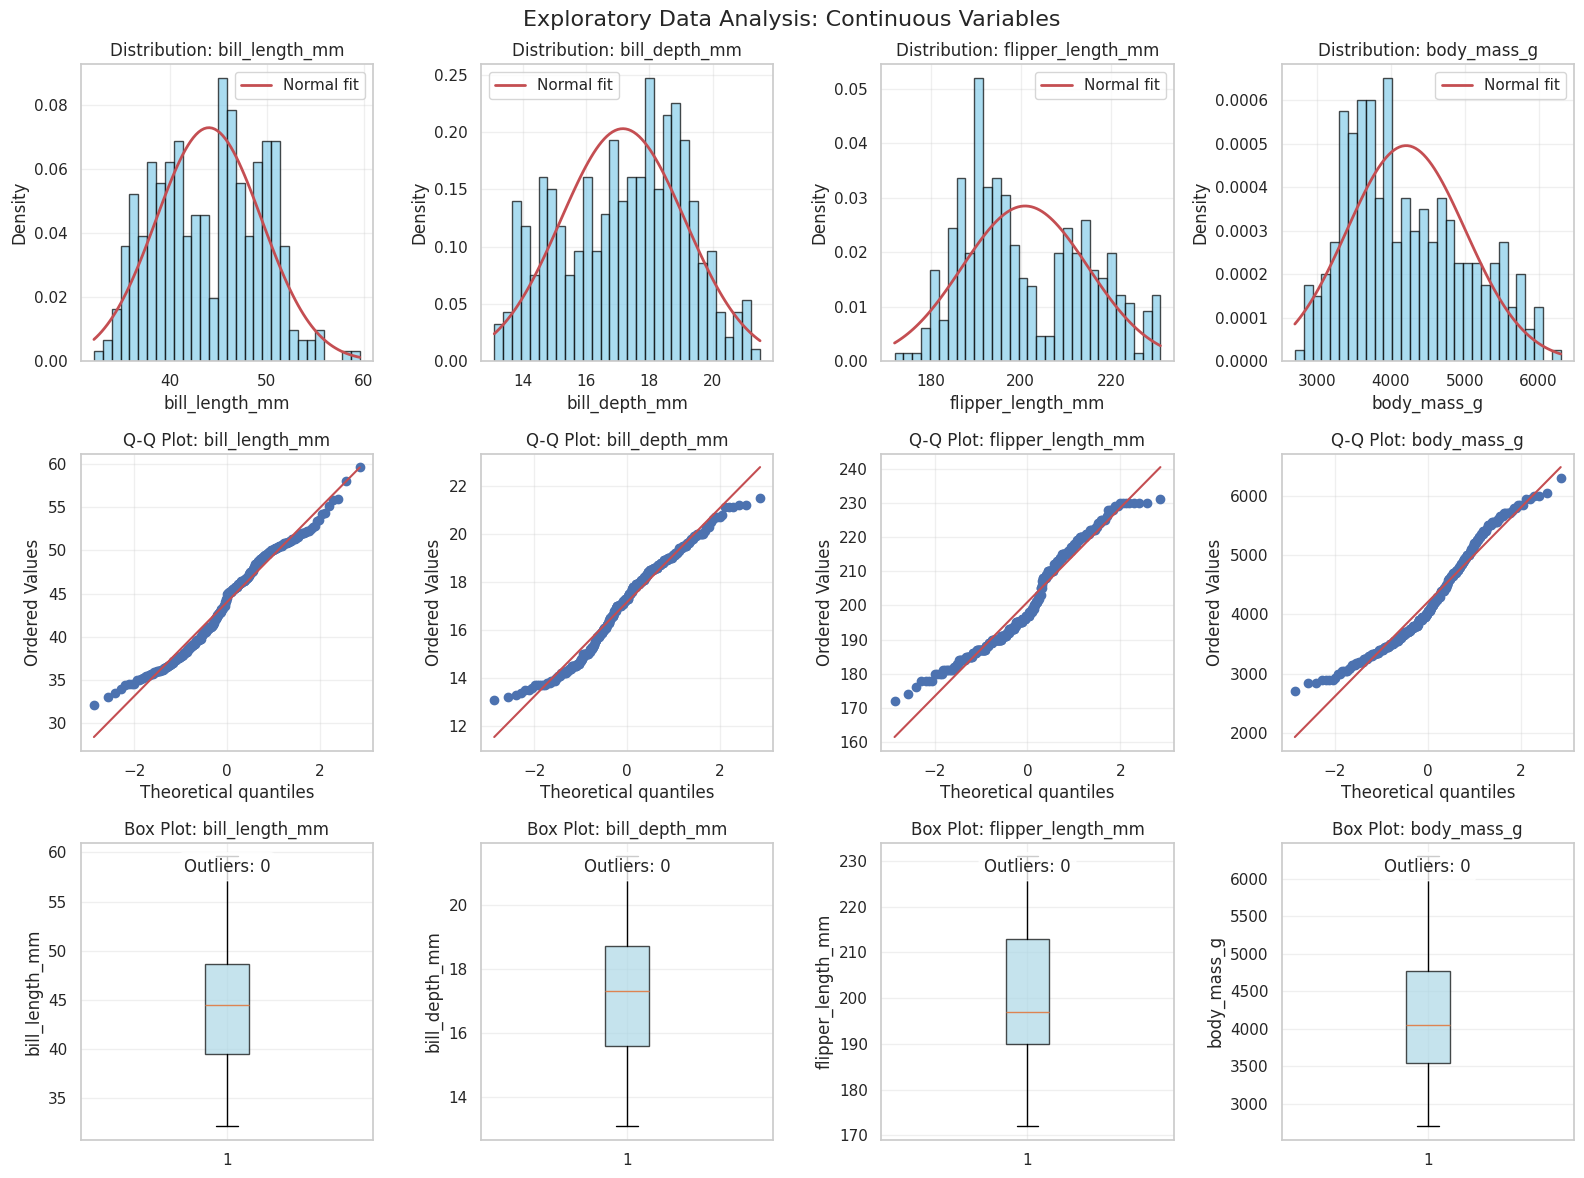


Outlier Analysis:
--------------------
bill_length_mm      :   0 outliers (  0.0%)
bill_depth_mm       :   0 outliers (  0.0%)
flipper_length_mm   :   0 outliers (  0.0%)
body_mass_g         :   0 outliers (  0.0%)

Species-specific Means:
-------------------------
           bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
species                                                                 
Adelie              38.82          18.35             190.10      3706.16
Chinstrap           48.83          18.42             195.82      3733.09
Gentoo              47.57          15.00             217.24      5092.44


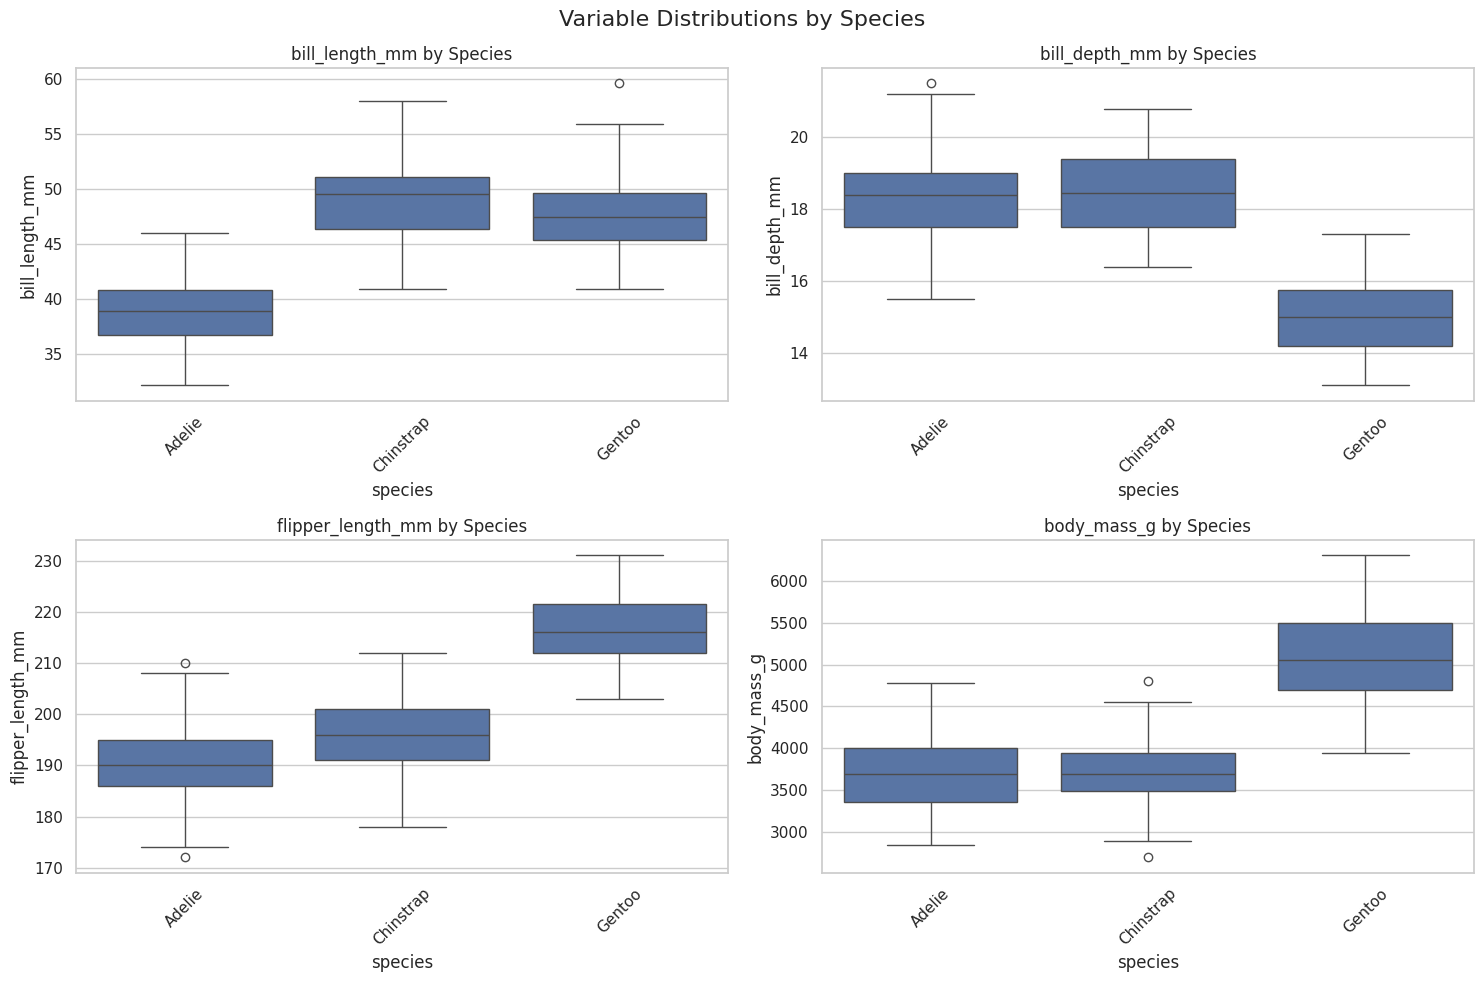

In [ ]:
def explore_correlation_data(data, continuous_vars):
    """
    Exploration of the dataset focusing on relationships between continuous variables.

    """
    print("\n" + "=" * 70)
    print("EXPLORATORY DATA ANALYSIS FOR CORRELATION")
    print("=" * 70)

    # Basic descriptive statistics
    print("\nDescriptive Statistics for Continuous Variables:")
    print("-" * 50)

    desc_stats = data[continuous_vars].describe().round(2)
    print(desc_stats)

    # Calculate coefficient of variation for each variable
    # Remember that CV helps to understand the extent of dispersion or variability around the mean of a dataset.
    print(f"\nCoefficient of Variation (CV = std/mean):")
    print("-" * 40)
    for var in continuous_vars:
        mean_val = data[var].mean()
        std_val = data[var].std()
        cv = (std_val / mean_val) * 100
        print(f"{var:<20}: {cv:>6.1f}%")

    # Check distributions for normality (important for Pearson correlation)
    print(f"\nNormality Assessment (Shapiro-Wilk Test):")
    print("-" * 45)
    normality_results = {}

    for var in continuous_vars:
        # Use sample if data is too large for Shapiro-Wilk
        sample_data = data[var].dropna()
        if len(sample_data) > 5000:
            sample_data = sample_data.sample(5000, random_state=42)

        stat, p_value = stats.shapiro(sample_data)
        normality_results[var] = {'statistic': stat, 'p_value': p_value}

        interpretation = "Normal" if p_value > 0.05 else "Non-normal"
        print(f"{var:<20}: W = {stat:.4f}, p = {p_value:.4f} ({interpretation})")

    # Create different visualizations
    n_vars = len(continuous_vars)
    fig, axes = plt.subplots(3, n_vars, figsize=(4*n_vars, 12))
    fig.suptitle('Exploratory Data Analysis: Continuous Variables', fontsize=16)

    for i, var in enumerate(continuous_vars):
        var_data = data[var].dropna()

        # Row 1: Histograms with normal overlay
        axes[0, i].hist(var_data, bins=30, density=True, alpha=0.7,
                       color='skyblue', edgecolor='black')

        # Overlay normal distribution
        mu, sigma = stats.norm.fit(var_data)
        x = np.linspace(var_data.min(), var_data.max(), 100)
        axes[0, i].plot(x, stats.norm.pdf(x, mu, sigma), 'r-',
                       linewidth=2, label='Normal fit')

        axes[0, i].set_title(f'Distribution: {var}')
        axes[0, i].set_xlabel(var)
        axes[0, i].set_ylabel('Density')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Row 2: Q-Q plots for normality
        stats.probplot(var_data, dist="norm", plot=axes[1, i])
        axes[1, i].set_title(f'Q-Q Plot: {var}')
        axes[1, i].grid(True, alpha=0.3)

        # Row 3: Box plots
        axes[2, i].boxplot(var_data, patch_artist=True,
                          boxprops=dict(facecolor='lightblue', alpha=0.7))
        axes[2, i].set_title(f'Box Plot: {var}')
        axes[2, i].set_ylabel(var)
        axes[2, i].grid(True, alpha=0.3)

        # Add outlier information
        Q1 = var_data.quantile(0.25)
        Q3 = var_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = var_data[(var_data < lower_bound) | (var_data > upper_bound)]

        axes[2, i].text(0.5, 0.95, f'Outliers: {len(outliers)}',
                       transform=axes[2, i].transAxes, ha='center', va='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Identify potential outliers
    print(f"\nOutlier Analysis:")
    print("-" * 20)

    outlier_summary = {}
    for var in continuous_vars:
        var_data = data[var].dropna()
        Q1 = var_data.quantile(0.25)
        Q3 = var_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = var_data[(var_data < lower_bound) | (var_data > upper_bound)]
        outlier_percentage = (len(outliers) / len(var_data)) * 100

        outlier_summary[var] = {
            'count': len(outliers),
            'percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

        print(f"{var:<20}: {len(outliers):>3} outliers ({outlier_percentage:>5.1f}%)")

    # Species-specific analysis
    if 'species' in data.columns:
        print(f"\nSpecies-specific Means:")
        print("-" * 25)
        species_means = data.groupby('species')[continuous_vars].mean().round(2)
        print(species_means)

        # Visualize species differences
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Variable Distributions by Species', fontsize=16)

        for i, var in enumerate(continuous_vars):
            row = i // 2
            col = i % 2

            sns.boxplot(data=data, x='species', y=var, ax=axes[row, col])
            axes[row, col].set_title(f'{var} by Species')
            axes[row, col].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    return {
        'descriptive_stats': desc_stats,
        'normality_results': normality_results,
        'outlier_summary': outlier_summary,
        'species_means': species_means if 'species' in data.columns else None
    }

# Step 1: Explore the data
exploration_results = explore_correlation_data(penguins_clean, continuous_vars)

# Correlation Concepts: Visual Demonstration
This section builds intuition about correlation by showing what different correlation strengths actually look like in scatter plots. We'll generate simulated data with known correlations (ranging from r = -0.9 to r = +0.9) so you can see how the strength and direction of relationships appear visually. This visual foundation will help you better interpret the correlations we find in the real penguin data that follows.

**The correlated data is generated by:**

Constructing a covariance matrix where the off-diagonal value is the target correlation r

Sampling from a multivariate normal distribution using that covariance structure. The multivariate normal distribution inherently supports specifying correlation (or covariance) between variables.



This approach guarantees that the resulting synthetic data pairs (x, y) have the desired correlation structure.


CORRELATION CONCEPTS: VISUAL DEMONSTRATION


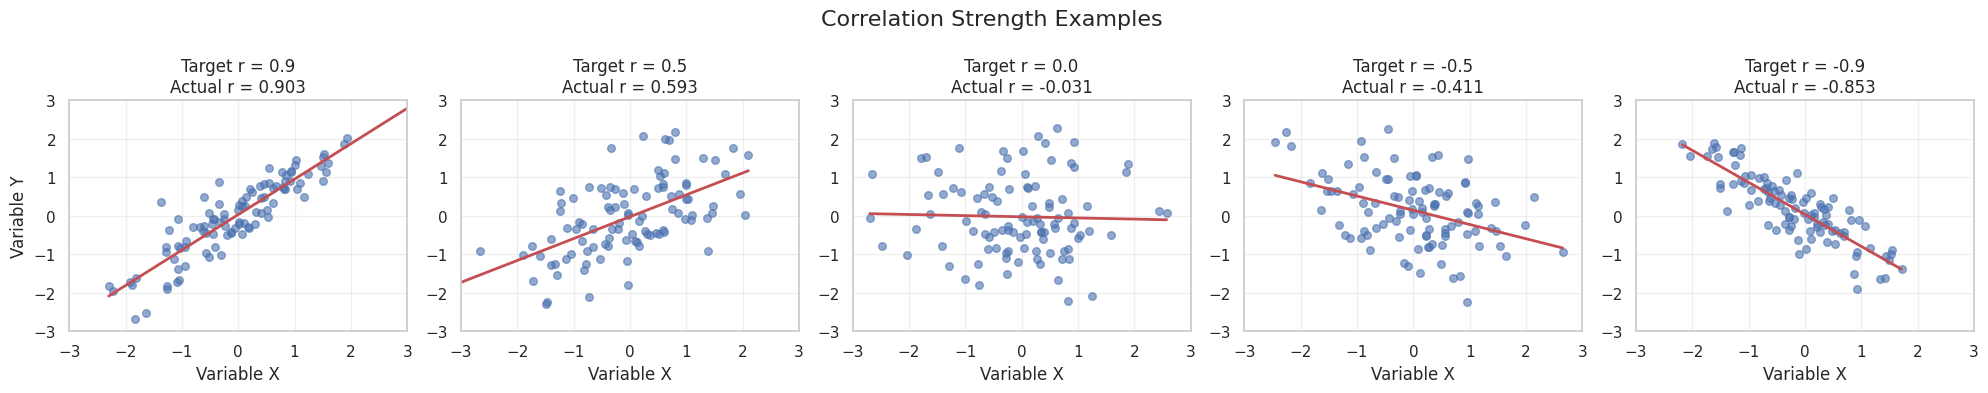


Correlation Interpretation Guide:
-----------------------------------
Perfect positive (r = +1.0)   : Y increases exactly as X increases
Strong positive (r = +0.7 to +0.9): Y tends to increase as X increases
Moderate positive (r = +0.3 to +0.7): Y somewhat increases as X increases
Weak (r = -0.3 to +0.3)       : Little to no linear relationship
Moderate negative (r = -0.7 to -0.3): Y somewhat decreases as X increases
Strong negative (r = -0.9 to -0.7): Y tends to decrease as X increases
Perfect negative (r = -1.0)   : Y decreases exactly as X increases


In [ ]:
def demonstrate_correlation_concepts():
    """
    Demonstrate correlation concepts with simulated examples to build intuition.
    We will then look at our penguin dataset
    """
    print("\n" + "=" * 70)
    print("CORRELATION CONCEPTS: VISUAL DEMONSTRATION")
    print("=" * 70)

    # Generate example data with different correlation strengths
    np.random.seed(42)
    n = 100
    x = np.random.normal(0, 1, n)

    # Create different correlation scenarios
    correlations = [0.9, 0.5, 0.0, -0.5, -0.9]
    correlation_data = {}

    for r in correlations:
        # Generate correlated data using Cholesky decomposition
        cov_matrix = np.array([[1, r], [r, 1]])
        data_pair = np.random.multivariate_normal([0, 0], cov_matrix, n)
        correlation_data[r] = {'x': data_pair[:, 0], 'y': data_pair[:, 1]}

    # Create visualization
    fig, axes = plt.subplots(1, len(correlations), figsize=(20, 4))
    fig.suptitle('Correlation Strength Examples', fontsize=16)

    for i, r in enumerate(correlations):
        x_data = correlation_data[r]['x']
        y_data = correlation_data[r]['y']

        # Calculate actual correlation
        actual_r, _ = pearsonr(x_data, y_data)

        # Create scatter plot
        axes[i].scatter(x_data, y_data, alpha=0.6, s=30)

        # Add regression line
        slope, intercept, _, _, _ = stats.linregress(x_data, y_data)
        line_x = np.linspace(x_data.min(), x_data.max(), 100)
        line_y = slope * line_x + intercept
        axes[i].plot(line_x, line_y, 'r-', linewidth=2)

        # Formatting
        axes[i].set_title(f'Target r = {r}\nActual r = {actual_r:.3f}')
        axes[i].set_xlabel('Variable X')
        if i == 0:
            axes[i].set_ylabel('Variable Y')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)

    plt.tight_layout()
    plt.show()

    # Interpretation guide
    print(f"\nCorrelation Interpretation Guide:")
    print("-" * 35)
    interpretation_guide = {
        "Perfect positive (r = +1.0)": "Y increases exactly as X increases",
        "Strong positive (r = +0.7 to +0.9)": "Y tends to increase as X increases",
        "Moderate positive (r = +0.3 to +0.7)": "Y somewhat increases as X increases",
        "Weak (r = -0.3 to +0.3)": "Little to no linear relationship",
        "Moderate negative (r = -0.7 to -0.3)": "Y somewhat decreases as X increases",
        "Strong negative (r = -0.9 to -0.7)": "Y tends to decrease as X increases",
        "Perfect negative (r = -1.0)": "Y decreases exactly as X increases"
    }

    for strength, description in interpretation_guide.items():
        print(f"{strength:<30}: {description}")


  # Step 2: Demonstrate correlation concepts
demonstrate_correlation_concepts()

# Basic Pearson Correlations Analysis

## What We're Calculating

This section computes **Pearson correlations between all pairs** of continuous variables in our penguin dataset and provides a comprehensive interpretation of the relationships.

---

## Key Outputs

### 1. **Correlation Matrix**
- Shows all pairwise correlations in a structured table
- Values range from -1 to +1
- Diagonal is always 1.0 (variables correlate perfectly with themselves)

### 2. **Statistical Significance Testing**
- **p-values**: Test whether correlations are significantly different from zero
- **Sample sizes**: Number of complete observations for each pair
- **Significance threshold**: p < 0.05 indicates non-random relationship

### 3. **Strength Classification**
- **Strong**: |r| ≥ 0.7 (variables move together closely)
- **Moderate**: 0.3 ≤ |r| < 0.7 (noticeable relationship)
- **Weak**: |r| < 0.3 (little linear relationship)

### 4. **Visual Heatmap**
- Color-coded correlation matrix
- **Red**: Negative correlations
- **Blue**: Positive correlations  
- **Intensity**: Stronger correlations = darker colors

---

## What to Look For

**Strong Correlations**: Variables that might be measuring similar biological traits or have functional relationships

**Unexpected Patterns**: Correlations that don't make biological sense (potential confounding)

**Significance vs. Strength**: Large correlations that aren't significant (small sample) or small correlations that are significant (large sample)

This foundation analysis will guide our deeper investigation into species effects and causal relationships.

## Additional explanation, if you are still confused...

**What the correlation is doing:**

- Takes ALL penguins (regardless of species - Adelie, Chinstrap, Gentoo)
- For each individual penguin, looks at both bill_length and bill_depth (or any two variables)
- Asks the question: "Across all these penguins, when bill_length is higher, does bill_depth tend to be higher too?"
- Quantifies this relationship using Pearson's correlation formula
- The correlation pools all species together, so it's asking: "In general, across all penguin types, do longer bills tend to be deeper?"

But this can sometimes be misleading because:

Different species might have systematically different bill shapes. The correlation might be driven by between-species differences rather than within-species relationships

That's why we will later look at Partial correlations (controlling for species)


BASIC PEARSON CORRELATIONS
Correlation Matrix:
--------------------
                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm              1.000         -0.229              0.653   
bill_depth_mm              -0.229          1.000             -0.578   
flipper_length_mm           0.653         -0.578              1.000   
body_mass_g                 0.589         -0.472              0.873   

                   body_mass_g  
bill_length_mm           0.589  
bill_depth_mm           -0.472  
flipper_length_mm        0.873  
body_mass_g              1.000  

Pairwise Correlations:
-------------------------
bill_length_mm ↔ bill_depth_mm:
  r =  -0.229, p =  0.0000, n = 333
  Weak negative correlation (significant)

bill_length_mm ↔ flipper_length_mm:
  r =   0.653, p =  0.0000, n = 333
  Moderate positive correlation (significant)

bill_length_mm ↔ body_mass_g:
  r =   0.589, p =  0.0000, n = 333
  Moderate positive correlation (significant)

bill_depth_mm ↔ f

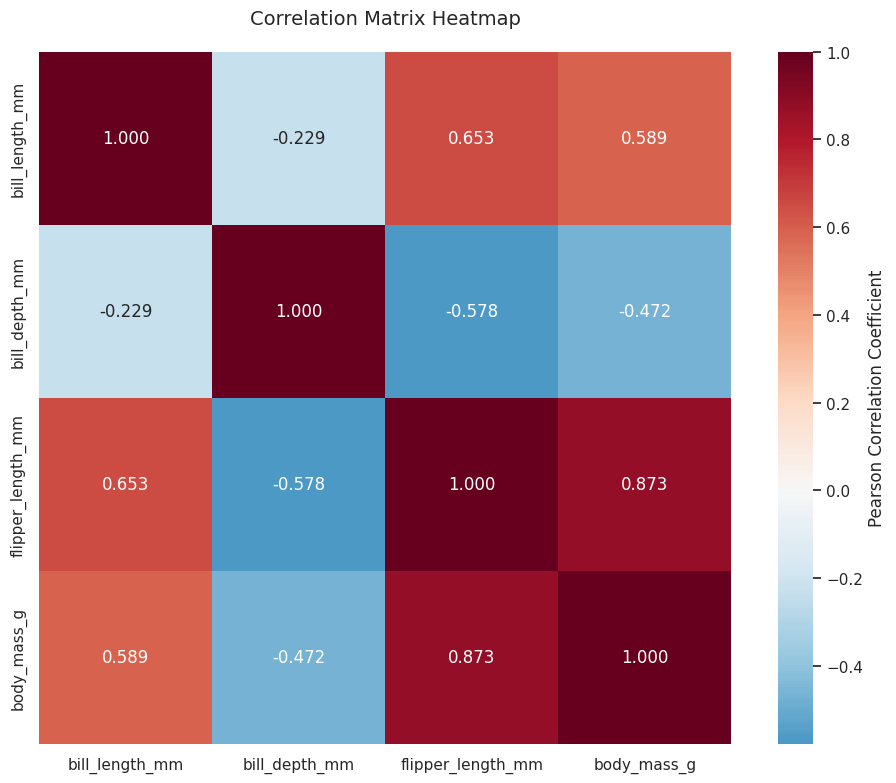

Correlation Summary:
--------------------
Number of correlations: 6
Mean |correlation|: 0.566
Max |correlation|: 0.873
Min |correlation|: 0.229

Correlations by strength:
  Weak: 1 (16.7%)
  Moderate: 4 (66.7%)
  Strong: 1 (16.7%)

Significant correlations: 6 out of 6


In [ ]:
def calculate_basic_correlations(data, continuous_vars):
    """
    Calculate and interpret basic Pearson correlations between continuous variables.

    """
    print("\n" + "=" * 70)
    print("BASIC PEARSON CORRELATIONS")
    print("=" * 70)

    # Calculate correlation matrix
    corr_matrix = data[continuous_vars].corr()

    print("Correlation Matrix:")
    print("-" * 20)
    print(corr_matrix.round(3))

    # Extract unique pairs and their correlations
    print(f"\nPairwise Correlations:")
    print("-" * 25)

    correlation_results = []

    for i in range(len(continuous_vars)):
        for j in range(i+1, len(continuous_vars)):
            var1 = continuous_vars[i]
            var2 = continuous_vars[j]

            # FIXED: Calculate correlation with proper alignment
            # Get valid pairs first to ensure alignment
            valid_pairs = data[[var1, var2]].dropna()

            # Calculate correlation and significance test on aligned data
            r, p_value = pearsonr(valid_pairs[var1], valid_pairs[var2])

            # Calculate sample size
            n = len(valid_pairs)

            # Interpret strength
            if abs(r) >= 0.7:
                strength = "Strong"
            elif abs(r) >= 0.3:
                strength = "Moderate"
            else:
                strength = "Weak"

            # Interpret direction
            direction = "Positive" if r > 0 else "Negative"

            # Significance
            significance = "Significant" if p_value < 0.05 else "Not significant"

            correlation_results.append({
                'var1': var1,
                'var2': var2,
                'correlation': r,
                'p_value': p_value,
                'n': n,
                'strength': strength,
                'direction': direction,
                'significance': significance
            })

            print(f"{var1} ↔ {var2}:")
            print(f"  r = {r:>7.3f}, p = {p_value:>7.4f}, n = {n:>3}")
            print(f"  {strength} {direction.lower()} correlation ({significance.lower()})")
            print()

    # Create correlation heatmap
    plt.figure(figsize=(10, 8))

    # Create mask for upper triangle to show only lower triangle
    #mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Create heatmap
    sns.heatmap(corr_matrix,
                #mask=mask,
                annot=True,
                cmap='RdBu_r',
                center=0,
                square=True,
                fmt='.3f',
                cbar_kws={'label': 'Pearson Correlation Coefficient'})

    plt.title('Correlation Matrix Heatmap', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"Correlation Summary:")
    print("-" * 20)

    correlations_flat = [abs(result['correlation']) for result in correlation_results]
    print(f"Number of correlations: {len(correlations_flat)}")
    print(f"Mean |correlation|: {np.mean(correlations_flat):.3f}")
    print(f"Max |correlation|: {np.max(correlations_flat):.3f}")
    print(f"Min |correlation|: {np.min(correlations_flat):.3f}")

    # Count by strength
    strength_counts = {}
    for result in correlation_results:
        strength = result['strength']
        strength_counts[strength] = strength_counts.get(strength, 0) + 1

    print(f"\nCorrelations by strength:")
    for strength, count in strength_counts.items():
        percentage = (count / len(correlation_results)) * 100
        print(f"  {strength}: {count} ({percentage:.1f}%)")

    # Significant correlations
    significant_corrs = [r for r in correlation_results if r['significance'] == 'Significant']
    print(f"\nSignificant correlations: {len(significant_corrs)} out of {len(correlation_results)}")

    return {
        'correlation_matrix': corr_matrix,
        'pairwise_results': correlation_results,
        'summary_stats': {
            'mean_abs_correlation': np.mean(correlations_flat),
            'max_abs_correlation': np.max(correlations_flat),
            'min_abs_correlation': np.min(correlations_flat),
            'strength_distribution': strength_counts,
            'significant_count': len(significant_corrs)
        }
    }


# Step 3: Calculate basic correlations
correlation_results = calculate_basic_correlations(penguins_clean, continuous_vars)

# Assumption Checking for Correlation Analysis

## Why Check Assumptions?

**Pearson correlation makes specific assumptions about the data.** When these assumptions are violated, the correlation coefficient can be misleading or unreliable. This section systematically tests each assumption and provides guidance on when to use alternative methods.

---

## Pearson Correlation Assumptions

### 1. **Linear Relationship**
- Variables should be linearly related (straight-line pattern)
- **Test**: Compare linear vs. quadratic model fit (R² values)
- **Violation**: Curved relationships reduce Pearson correlation strength

### 2. **Normal Distribution**
- Both variables should be approximately normally distributed
- **Test**: Shapiro-Wilk test, Q-Q plots
- **Violation**: Skewed data can distort correlation estimates

### 3. **Homoscedasticity**
- Constant variance across the range (equal spread). Basically, whether the spread of the data points around the regression line is consistent
- **Test**: Residuals vs. fitted values plot, Breusch-Pagan test
- **Violation**: Unequal variance can affect reliability

### 4. **No Extreme Outliers**
- Outliers can severely distort correlation coefficients
- **Tests**: Z-scores (>3), Mahalanobis distance for bivariate outliers
- **Violation**: Single outliers can create or hide relationships

### 5. **Independence**
- Observations should be independent
- **Assessment**: Consider data collection method
- **Violation**: Clustered or repeated measures require special handling

---

## What This Analysis Does

### How We Test Each Assumption

#### **Linearity Test**
- **Method**: Fit both linear (degree 1) and quadratic (degree 2) polynomial models
- **Comparison**: Calculate R² for each model
- **Decision rule**: If quadratic R² improvement < 0.05, relationship is sufficiently linear. If adding a curved term only explains 5% more variance, the straight-line relationship is adequate for correlation analysis.
- **Why this works**: Non-linear relationships will show substantial improvement with quadratic terms. Curved relationships are better captured by quadratic models, so a large R² jump (>0.05) indicates the linear correlation is missing important non-linear patterns.

- **Dumbing it down**: We fit a straight line and a curved line to the data and compare how well each explains the relationship. If the curved line only explains 5% more variance than the straight line, we conclude the relationship is linear enough for Pearson correlation..

#### **Normality Test**
- **Method**: Shapiro-Wilk test for each variable
- **Null hypothesis**: Data comes from normal distribution
- **Decision rule**: p > 0.05 suggests normality
- **Sample size limit**: Uses sample of 5000 if dataset is larger
- **Visual check**: Q-Q plots show departures from straight line

- **Dumbing it down**: We run a Shapiro-Wilk statistical test on each variable to check if it follows a normal (bell-shaped) distribution. If the p-value is greater than 0.05, we assume the variable is normal enough for Pearson correlation.

#### **Homoscedasticity Test**
- **Method**: Simplified Breusch-Pagan test
- **Process**: Calculate residuals from linear regression, then correlate |residuals| with fitted values
- **Logic**: If variance is constant, residuals shouldn't correlate with predicted values
- **Decision rule**: p > 0.05 suggests constant variance

- **Dumbing it down**: We calculate residuals (errors) from a linear regression, then check if the absolute residuals correlate with the predicted values. If there's no significant correlation (p > 0.05), it means the variance is constant across all values.

#### **Outlier Detection**
- **Univariate outliers**: Z-scores > 3 (more than 3 standard deviations from mean)
- **Bivariate outliers**: Mahalanobis distance with chi-square threshold
- **Mahalanobis distance**: Measures how far a point is from the center of data in a multi-dimensional space
- **Threshold**: χ² critical value at 99.9% confidence for 2 variables
- **Warning level**: >5% outliers suggests attention needed

- **Dumbing it down**: For univariate outliers, we identify points more than 3 standard deviations from the mean using z-scores. For bivariate outliers, we calculate Mahalanobis distance (which accounts for the correlation between variables) and flag points that exceed the chi-square threshold at 99.9% confidence. If more than 5% of data points are flagged as outliers by either method, we consider this problematic for correlation analysis.

### Visual Diagnostics
- **Scatter plots**: Linear vs. curved relationships
- **Q-Q plots**: Departure from normality
- **Residual plots**: Homoscedasticity violations
- **Outlier plots**: Mahalanobis distance detection

### Recommendations
- **All assumptions met**: Use Pearson correlation confidently
- **Some violations**: Compare Pearson vs. Spearman results
- **Major violations**: Prefer Spearman rank correlation

---

## Spearman's Rank Correlation

### When to Use Spearman
- **Non-normal data**: Robust to distribution shape
- **Non-linear monotonic relationships**: Captures consistent increasing/decreasing trends
- **Outlier presence**: Less sensitive to extreme values
- **Ordinal data**: Works with ranked data

### Interpretation
- **ρ (rho)**: Spearman correlation coefficient
- **Values**: Same range as Pearson (-1 to +1)
- **Meaning**: Strength of monotonic (consistently increasing/decreasing) relationship

### Comparison Strategy
This analysis compares Pearson vs. Spearman correlations to reveal:
- **High agreement**: Linear relationships with normal data
- **Moderate disagreement**: Some non-linearity or outliers present
- **Major disagreement**: Serious assumption violations

When assumptions are violated, **Spearman provides more reliable estimates** of the true relationship strength.


 EXECUTING ASSUMPTION CHECKING AND SPEARMAN ANALYSIS

 Step 1: Checking correlation assumptions for key variable pairs

COMPREHENSIVE PENGUIN CORRELATION ANALYSIS

 Analyzing flipper_length_mm vs body_mass_g

ASSUMPTION CHECKING: flipper_length_mm vs body_mass_g
Sample size: 333 complete pairs

1. LINEAR RELATIONSHIP
-------------------------
Linear R² = 0.7621
Quadratic R² = 0.7781
R² improvement = 0.0160
Linearity assumption: SATISFIED

2. NORMALITY
---------------
flipper_length_mm: W = 0.9517, p = 0.0000 (Non-normal)
body_mass_g: W = 0.9580, p = 0.0000 (Non-normal)

3. HOMOSCEDASTICITY
--------------------
Breusch-Pagan-like test:
Correlation |residuals| vs fitted: r = -0.1205, p = 0.0278
Homoscedasticity assumption: VIOLATED

4. OUTLIER DETECTION
--------------------
Univariate outliers (|z| > 3):
  flipper_length_mm: 0 (0.0%)
  body_mass_g: 0 (0.0%)
Bivariate outliers (Mahalanobis): 0 (0.0%)
Outlier assumption: SATISFIED


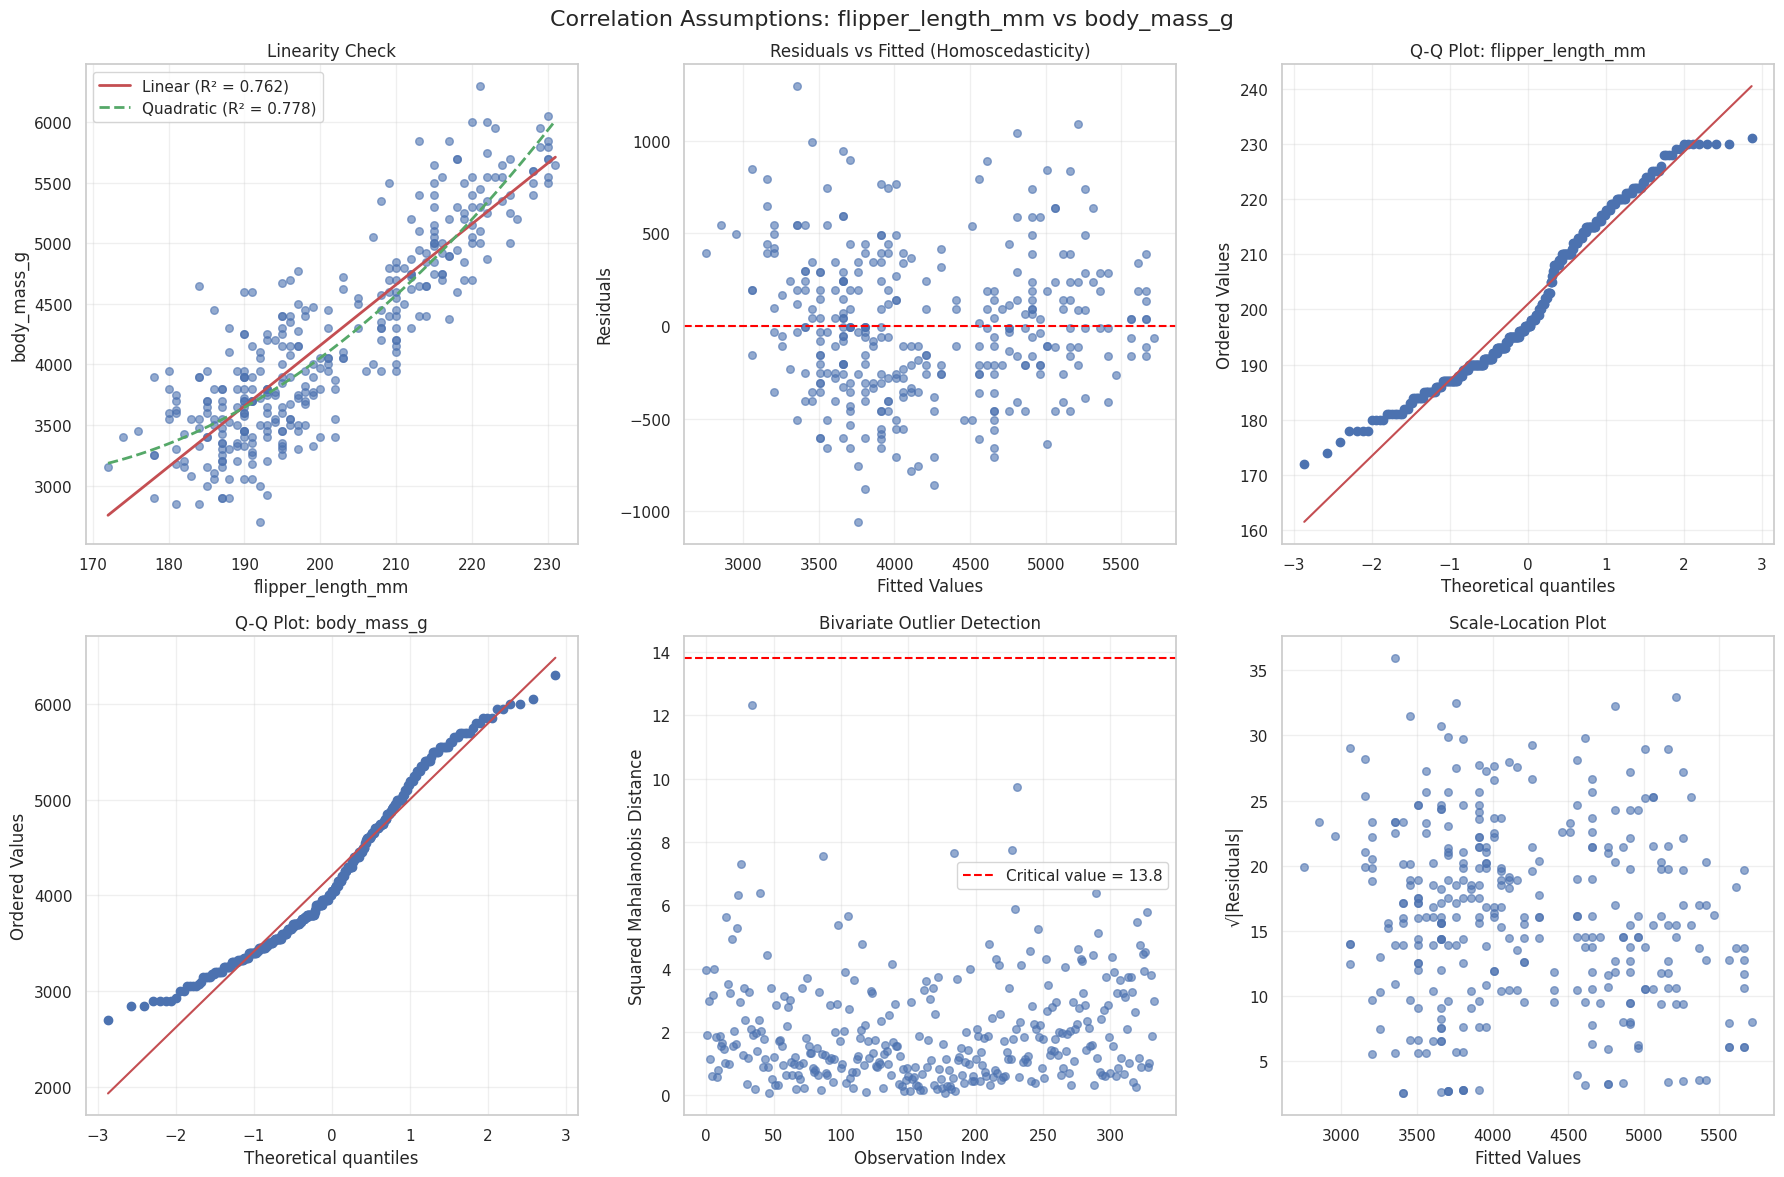


ASSUMPTION CHECK SUMMARY
Assumptions satisfied: 2/5
Recommendation: Consider both Pearson and Spearman correlations

 Analyzing bill_length_mm vs bill_depth_mm

ASSUMPTION CHECKING: bill_length_mm vs bill_depth_mm
Sample size: 333 complete pairs

1. LINEAR RELATIONSHIP
-------------------------
Linear R² = 0.0523
Quadratic R² = 0.1095
R² improvement = 0.0573
Linearity assumption: QUESTIONABLE

2. NORMALITY
---------------
bill_length_mm: W = 0.9743, p = 0.0000 (Non-normal)
bill_depth_mm: W = 0.9733, p = 0.0000 (Non-normal)

3. HOMOSCEDASTICITY
--------------------
Breusch-Pagan-like test:
Correlation |residuals| vs fitted: r = -0.2657, p = 0.0000
Homoscedasticity assumption: VIOLATED

4. OUTLIER DETECTION
--------------------
Univariate outliers (|z| > 3):
  bill_length_mm: 0 (0.0%)
  bill_depth_mm: 0 (0.0%)
Bivariate outliers (Mahalanobis): 0 (0.0%)
Outlier assumption: SATISFIED


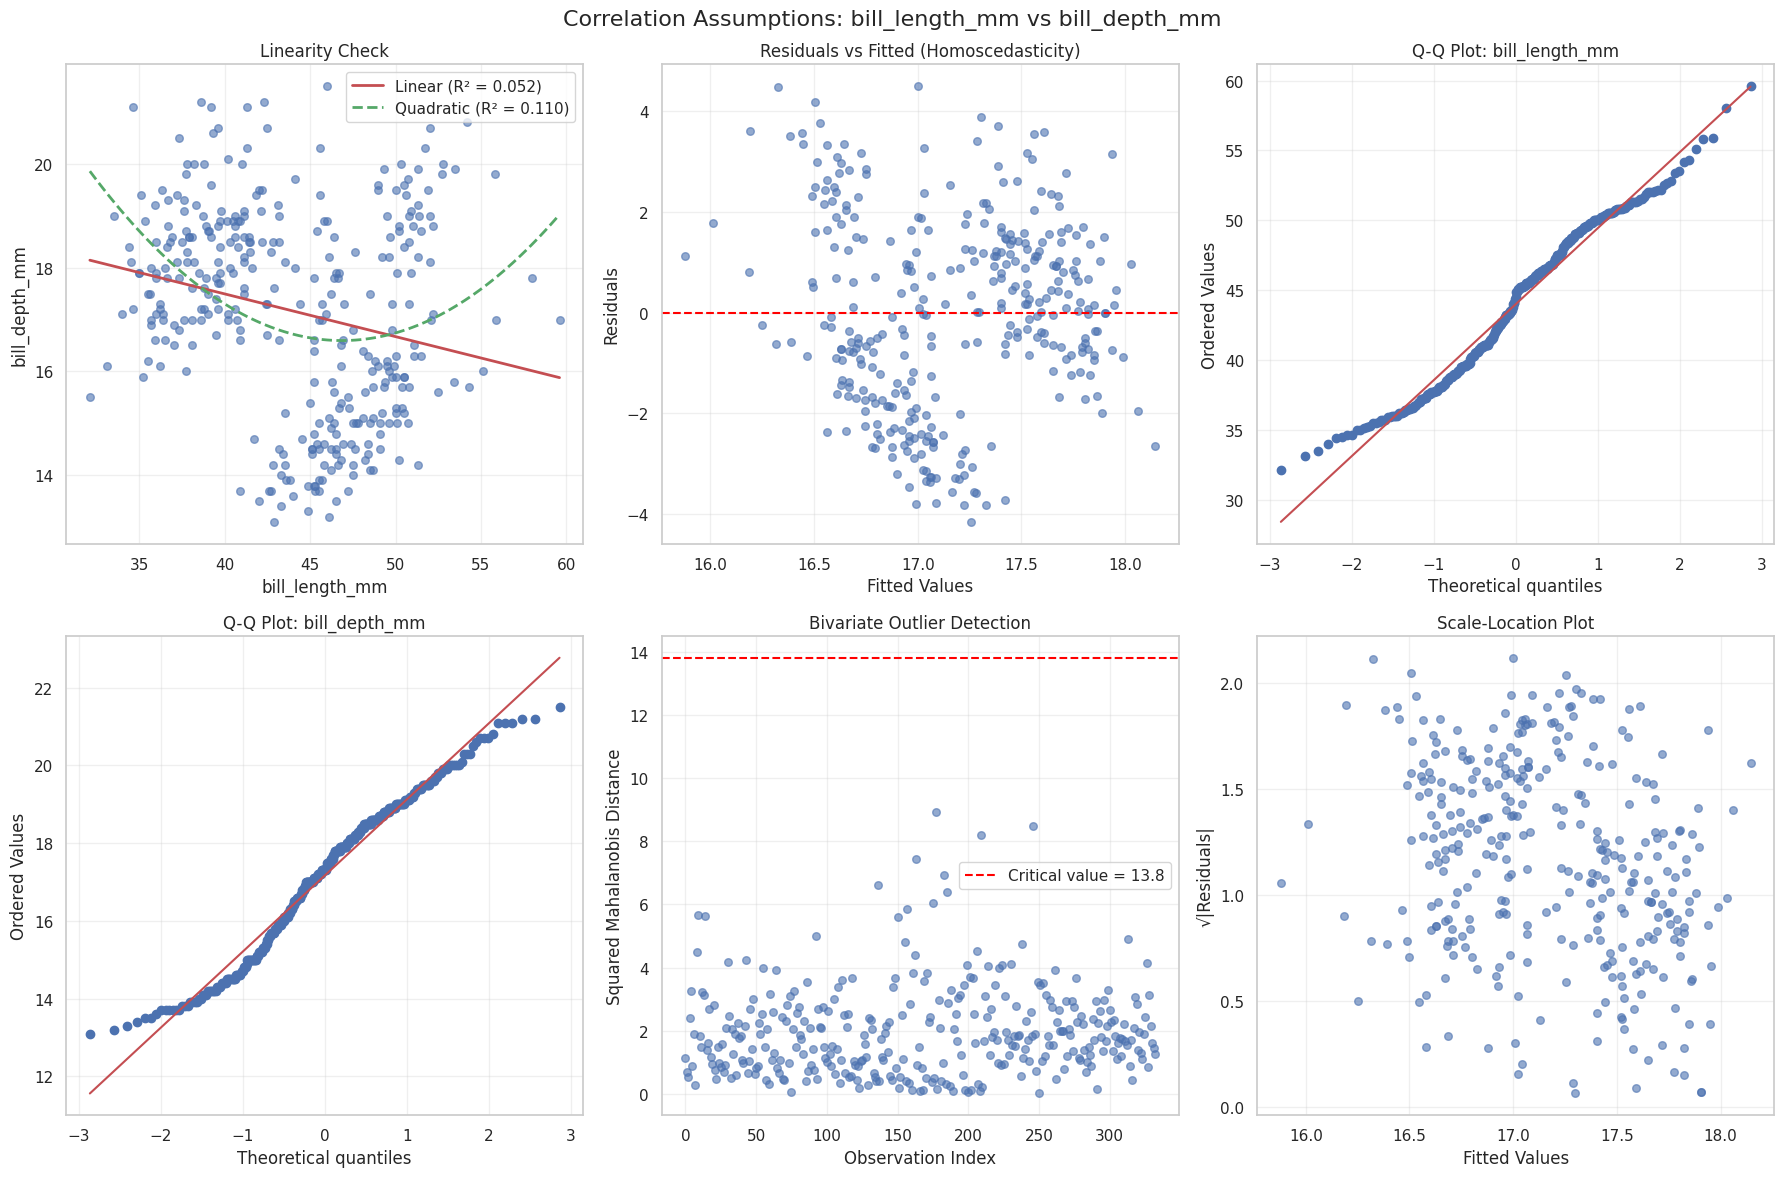


ASSUMPTION CHECK SUMMARY
Assumptions satisfied: 1/5
Recommendation: Spearman correlation recommended

 Analyzing bill_length_mm vs body_mass_g

ASSUMPTION CHECKING: bill_length_mm vs body_mass_g
Sample size: 333 complete pairs

1. LINEAR RELATIONSHIP
-------------------------
Linear R² = 0.3475
Quadratic R² = 0.3604
R² improvement = 0.0130
Linearity assumption: SATISFIED

2. NORMALITY
---------------
bill_length_mm: W = 0.9743, p = 0.0000 (Non-normal)
body_mass_g: W = 0.9580, p = 0.0000 (Non-normal)

3. HOMOSCEDASTICITY
--------------------
Breusch-Pagan-like test:
Correlation |residuals| vs fitted: r = 0.5155, p = 0.0000
Homoscedasticity assumption: VIOLATED

4. OUTLIER DETECTION
--------------------
Univariate outliers (|z| > 3):
  bill_length_mm: 0 (0.0%)
  body_mass_g: 0 (0.0%)
Bivariate outliers (Mahalanobis): 0 (0.0%)
Outlier assumption: SATISFIED


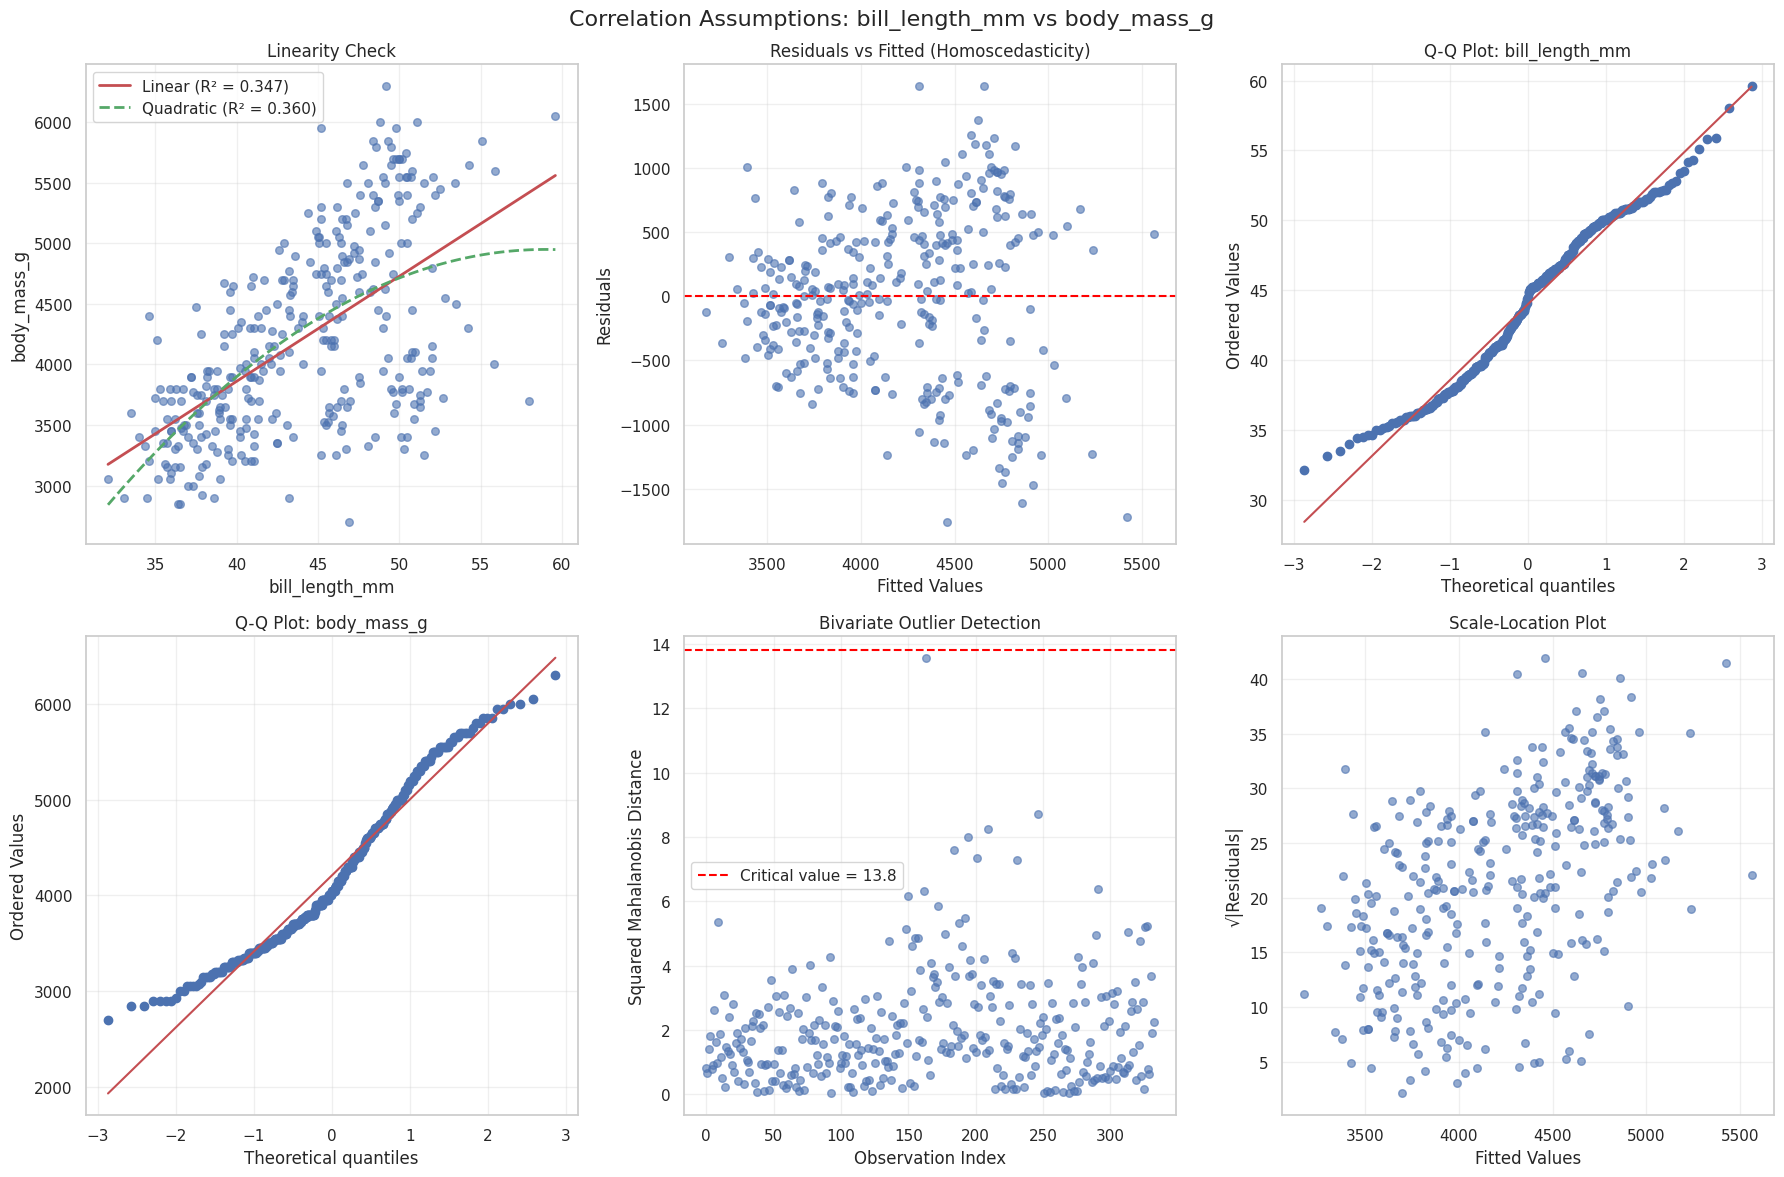


ASSUMPTION CHECK SUMMARY
Assumptions satisfied: 2/5
Recommendation: Consider both Pearson and Spearman correlations

ASSUMPTION CHECK SUMMARY FOR ALL PAIRS

flipper length mm ↔ body mass g:
  Assumptions met: 2/5
  Recommendation: Consider both Pearson and Spearman correlations
  Pearson r = 0.873

bill length mm ↔ bill depth mm:
  Assumptions met: 1/5
  Recommendation: Spearman correlation recommended
  Pearson r = -0.229

bill length mm ↔ body mass g:
  Assumptions met: 2/5
  Recommendation: Consider both Pearson and Spearman correlations
  Pearson r = 0.589

 Step 2: Spearman correlation analysis

SPEARMAN'S RANK CORRELATION ANALYSIS
Spearman's rank correlation (ρ) measures monotonic relationships
It's robust to outliers and doesn't assume normality or linearity

Spearman Correlation Matrix:
------------------------------
                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm              1.000         -0.214              0.670   
bill_depth_mm       

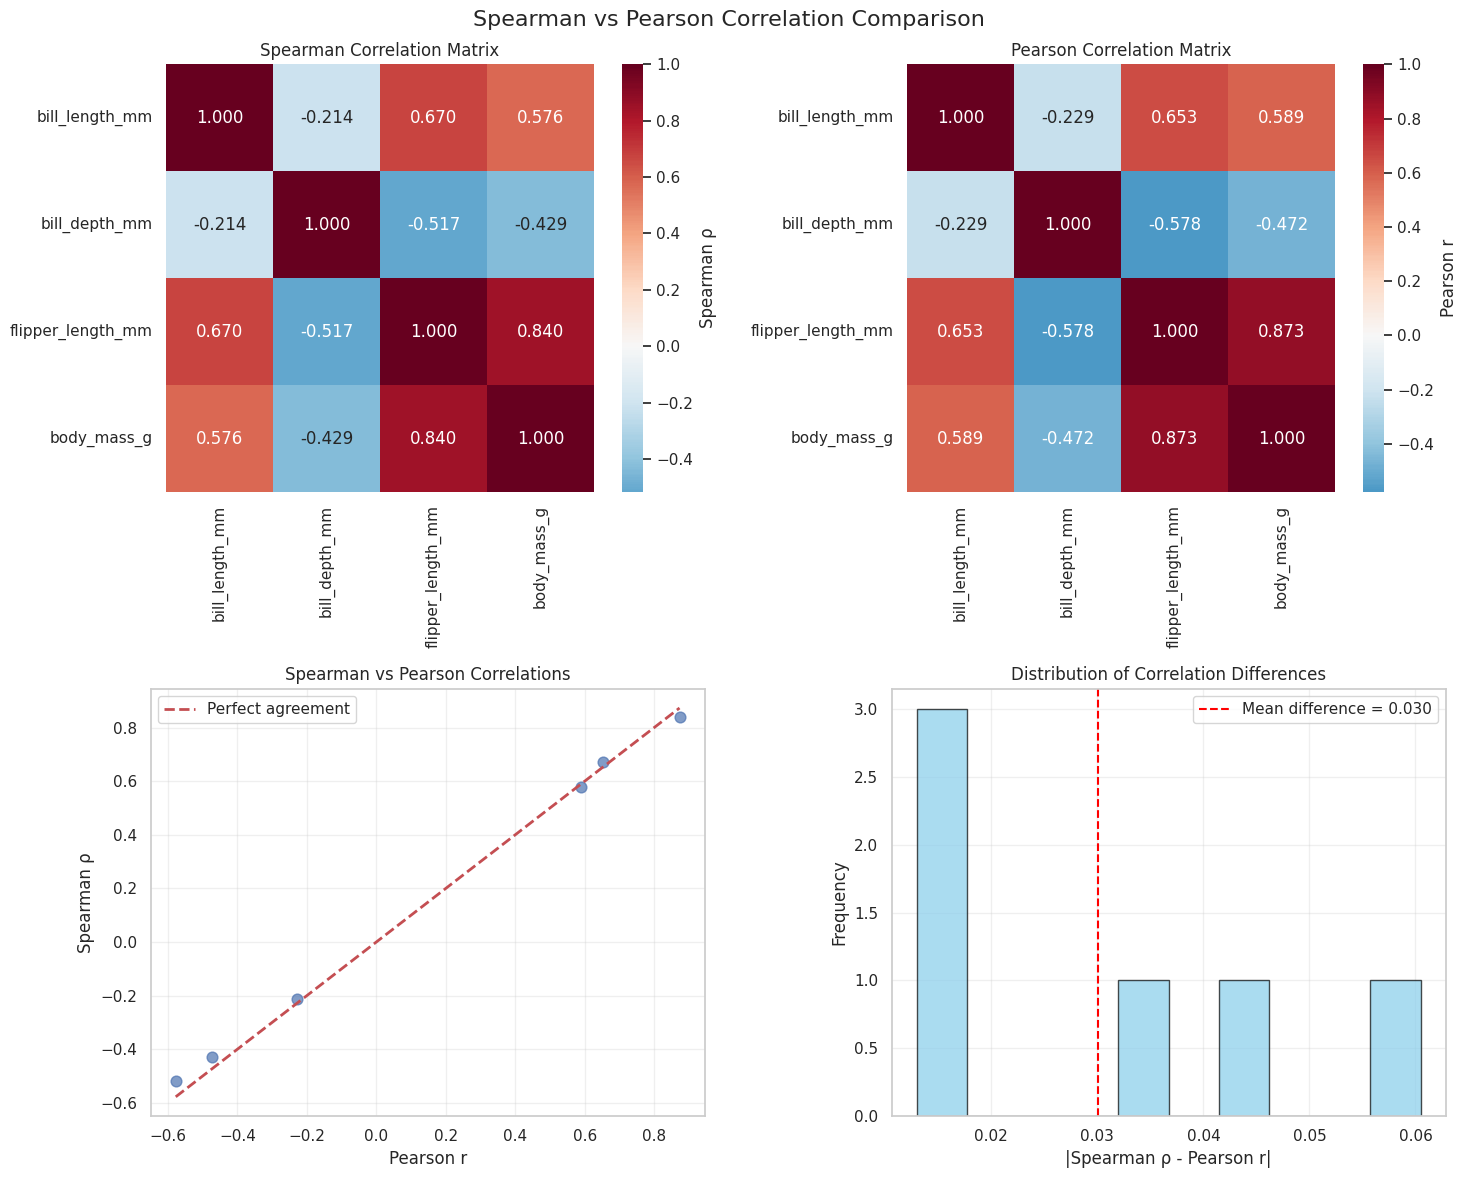

Comparison Summary:
--------------------
Mean absolute difference: 0.030
Maximum difference: 0.060
Number of pairs with |diff| > 0.1: 0
Number of pairs with |diff| > 0.2: 0


In [ ]:
def check_correlation_assumptions(data, var1, var2, create_plots=True):
    """
    Assumption checking for Pearson correlation between two variables.
    """
    print(f"\n" + "=" * 60)
    print(f"ASSUMPTION CHECKING: {var1} vs {var2}")
    print("=" * 60)

    # Get clean data for the pair
    clean_data = data[[var1, var2]].dropna()
    x = clean_data[var1]
    y = clean_data[var2]
    n = len(clean_data)

    print(f"Sample size: {n} complete pairs")

    # 1. Linear relationship check
    print(f"\n1. LINEAR RELATIONSHIP")
    print("-" * 25)

    # Calculate Pearson correlation
    r_pearson, p_pearson = pearsonr(x, y)

    # Fit polynomial models to test for non-linearity
    #Note: Remember that R-squared indicates how well the model fits the data
    # Linear model (degree 1)
    linear_coef = np.polyfit(x, y, 1)
    linear_pred = np.polyval(linear_coef, x)
    linear_r2 = 1 - (np.sum((y - linear_pred) ** 2) / np.sum((y - np.mean(y)) ** 2))

    # Quadratic model (degree 2)
    quad_coef = np.polyfit(x, y, 2)
    quad_pred = np.polyval(quad_coef, x)
    quad_r2 = 1 - (np.sum((y - quad_pred) ** 2) / np.sum((y - np.mean(y)) ** 2))

    # Test for non-linearity
    r2_improvement = quad_r2 - linear_r2
    linearity_ok = r2_improvement < 0.05  # Arbitrary threshold

    print(f"Linear R² = {linear_r2:.4f}")
    print(f"Quadratic R² = {quad_r2:.4f}")
    print(f"R² improvement = {r2_improvement:.4f}")
    print(f"Linearity assumption: {'SATISFIED' if linearity_ok else 'QUESTIONABLE'}")

    # 2. Normality check
    print(f"\n2. NORMALITY")
    print("-" * 15)

    # Shapiro-Wilk tests (use sample if too large)
    x_sample = x.sample(min(5000, len(x)), random_state=42) if len(x) > 5000 else x
    y_sample = y.sample(min(5000, len(y)), random_state=42) if len(y) > 5000 else y

    shapiro_x = stats.shapiro(x_sample)
    shapiro_y = stats.shapiro(y_sample)

    normality_x = shapiro_x.pvalue > 0.05
    normality_y = shapiro_y.pvalue > 0.05

    print(f"{var1}: W = {shapiro_x.statistic:.4f}, p = {shapiro_x.pvalue:.4f} ({'Normal' if normality_x else 'Non-normal'})")
    print(f"{var2}: W = {shapiro_y.statistic:.4f}, p = {shapiro_y.pvalue:.4f} ({'Normal' if normality_y else 'Non-normal'})")

    # 3. Homoscedasticity check
    print(f"\n3. HOMOSCEDASTICITY")
    print("-" * 20)

    # Calculate residuals from linear regression
    residuals = y - linear_pred

    # Breusch-Pagan test for heteroscedasticity
    # Simple version: correlation between |residuals| and fitted values
    abs_residuals = np.abs(residuals)
    fitted_values = linear_pred

    hetero_corr, hetero_p = pearsonr(fitted_values, abs_residuals)
    homoscedasticity_ok = hetero_p > 0.05

    print(f"Breusch-Pagan-like test:")
    print(f"Correlation |residuals| vs fitted: r = {hetero_corr:.4f}, p = {hetero_p:.4f}")
    print(f"Homoscedasticity assumption: {'SATISFIED' if homoscedasticity_ok else 'VIOLATED'}")

    # 4. Outlier detection
    print(f"\n4. OUTLIER DETECTION")
    print("-" * 20)

    # Z-score method for univariate outliers
    #Note: Remember that Z-score indicates how many standard deviations a data point is from the mean of a distribution
    z_scores_x = np.abs(stats.zscore(x))
    z_scores_y = np.abs(stats.zscore(y))

    outliers_x = np.sum(z_scores_x > 3)
    outliers_y = np.sum(z_scores_y > 3)

    # Bivariate outliers using Mahalanobis distance
    data_array = np.column_stack([x, y])    # Combine x and y into a 2D array
    mean_vec = np.mean(data_array, axis=0)   # Calculate mean of x and mean of y
    cov_matrix = np.cov(data_array.T)    # Calculate covariance matrix

    try:
        inv_cov = np.linalg.inv(cov_matrix)   # Invert the covariance matrix
        mahal_dist = []
        for i in range(len(data_array)):
            diff = data_array[i] - mean_vec   # How far this point is from the center
            mahal_dist.append(np.sqrt(diff.T @ inv_cov @ diff))  # Mahalanobis distance formula

        mahal_dist = np.array(mahal_dist)
        # Chi-square critical value for 2 variables at 99.9% confidence
        chi2_critical = stats.chi2.ppf(0.999, df=2)    # Get chi-square threshold for 99.9% confidence
        bivariate_outliers = np.sum(mahal_dist**2 > chi2_critical)  # Count outliers

    except np.linalg.LinAlgError:
        bivariate_outliers = 0
        mahal_dist = np.zeros(len(data_array))

    total_outliers = max(outliers_x, outliers_y, bivariate_outliers)
    outliers_ok = total_outliers < (0.05 * n)  # Less than 5% outliers

    print(f"Univariate outliers (|z| > 3):")
    print(f"  {var1}: {outliers_x} ({outliers_x/n*100:.1f}%)")
    print(f"  {var2}: {outliers_y} ({outliers_y/n*100:.1f}%)")
    print(f"Bivariate outliers (Mahalanobis): {bivariate_outliers} ({bivariate_outliers/n*100:.1f}%)")
    print(f"Outlier assumption: {'SATISFIED' if outliers_ok else 'ATTENTION NEEDED'}")

    # Create diagnostic plots if requested
    if create_plots:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f'Correlation Assumptions: {var1} vs {var2}', fontsize=16)

        # Plot 1: Scatter plot with linear and quadratic fits
        axes[0, 0].scatter(x, y, alpha=0.6, s=30)

        # Linear fit
        x_line = np.linspace(x.min(), x.max(), 100)
        y_linear = np.polyval(linear_coef, x_line)
        y_quad = np.polyval(quad_coef, x_line)

        axes[0, 0].plot(x_line, y_linear, 'r-', linewidth=2, label=f'Linear (R² = {linear_r2:.3f})')
        axes[0, 0].plot(x_line, y_quad, 'g--', linewidth=2, label=f'Quadratic (R² = {quad_r2:.3f})')

        axes[0, 0].set_xlabel(var1)
        axes[0, 0].set_ylabel(var2)
        axes[0, 0].set_title('Linearity Check')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # Plot 2: Residuals vs Fitted (homoscedasticity)
        axes[0, 1].scatter(fitted_values, residuals, alpha=0.6, s=30)
        axes[0, 1].axhline(y=0, color='red', linestyle='--')
        axes[0, 1].set_xlabel('Fitted Values')
        axes[0, 1].set_ylabel('Residuals')
        axes[0, 1].set_title('Residuals vs Fitted (Homoscedasticity)')
        axes[0, 1].grid(True, alpha=0.3)

        # Plot 3: Q-Q plot for X variable
        stats.probplot(x, dist="norm", plot=axes[0, 2])
        axes[0, 2].set_title(f'Q-Q Plot: {var1}')
        axes[0, 2].grid(True, alpha=0.3)

        # Plot 4: Q-Q plot for Y variable
        stats.probplot(y, dist="norm", plot=axes[1, 0])
        axes[1, 0].set_title(f'Q-Q Plot: {var2}')
        axes[1, 0].grid(True, alpha=0.3)

        # Plot 5: Outlier detection (Mahalanobis distance)
        if len(mahal_dist) > 0:
            axes[1, 1].scatter(range(len(mahal_dist)), mahal_dist**2, alpha=0.6, s=30)
            axes[1, 1].axhline(y=chi2_critical, color='red', linestyle='--',
                              label=f'Critical value = {chi2_critical:.1f}')
            axes[1, 1].set_xlabel('Observation Index')
            axes[1, 1].set_ylabel('Squared Mahalanobis Distance')
            axes[1, 1].set_title('Bivariate Outlier Detection')
            axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        # Plot 6: Scale-Location plot
        sqrt_abs_residuals = np.sqrt(np.abs(residuals))
        axes[1, 2].scatter(fitted_values, sqrt_abs_residuals, alpha=0.6, s=30)
        axes[1, 2].set_xlabel('Fitted Values')
        axes[1, 2].set_ylabel('√|Residuals|')
        axes[1, 2].set_title('Scale-Location Plot')
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # Summary
    assumptions_met = sum([linearity_ok, normality_x, normality_y, homoscedasticity_ok, outliers_ok])
    total_assumptions = 5

    print(f"\n" + "=" * 50)
    print("ASSUMPTION CHECK SUMMARY")
    print("=" * 50)
    print(f"Assumptions satisfied: {assumptions_met}/{total_assumptions}")

    if assumptions_met >= 4:
        recommendation = "Pearson correlation is appropriate"
    elif assumptions_met >= 2:
        recommendation = "Consider both Pearson and Spearman correlations"
    else:
        recommendation = "Spearman correlation recommended"

    print(f"Recommendation: {recommendation}")

    return {
        'linearity': linearity_ok,
        'normality_x': normality_x,
        'normality_y': normality_y,
        'homoscedasticity': homoscedasticity_ok,
        'outliers_ok': outliers_ok,
        'assumptions_met': assumptions_met,
        'recommendation': recommendation,
        'pearson_r': r_pearson,
        'sample_size': n,
        'outlier_counts': {
            'univariate_x': outliers_x,
            'univariate_y': outliers_y,
            'bivariate': bivariate_outliers
        }
    }


def perform_spearman_correlation(data, continuous_vars):
    """
    Perform Spearman's rank correlation analysis as a non-parametric alternative.
    """
    print(f"\n" + "=" * 70)
    print("SPEARMAN'S RANK CORRELATION ANALYSIS")
    print("=" * 70)

    print("Spearman's rank correlation (ρ) measures monotonic relationships")
    print("It's robust to outliers and doesn't assume normality or linearity")
    print()

    # Calculate Spearman correlation matrix - using pandas .corr function - all pairs results simultaneously
    # Note: The .corr(method='spearman' method automatically converts data to ranks
    spearman_matrix = data[continuous_vars].corr(method='spearman')

    print("Spearman Correlation Matrix:")
    print("-" * 30)
    print(spearman_matrix.round(3))

    # Compare with Pearson correlations
    pearson_matrix = data[continuous_vars].corr(method='pearson')

# Just so we can print p-values, let us do this individually, for each pair of variables at a time
# using the scipy.stats functions, which returns the p-values
    print(f"\nSpearman vs Pearson Correlations:")
    print("-" * 35)

    spearman_results = []

    for i in range(len(continuous_vars)):
        for j in range(i+1, len(continuous_vars)):
            var1 = continuous_vars[i]
            var2 = continuous_vars[j]

            # Get aligned data first, then calculate correlations
            clean_data = data[[var1, var2]].dropna()
            x = clean_data[var1]
            y = clean_data[var2]

            # Spearman correlation (using function from scipy.stats)
            rho, p_spearman = spearmanr(x, y)

            # Pearson correlation for comparison (using function from scipy.stats)
            r_pearson, p_pearson = pearsonr(x, y)

            # Calculate difference
            diff = abs(rho - r_pearson)

            spearman_results.append({
                'var1': var1,
                'var2': var2,
                'spearman_rho': rho,
                'spearman_p': p_spearman,
                'pearson_r': r_pearson,
                'pearson_p': p_pearson,
                'difference': diff,
                'sample_size': len(clean_data)
            })

            # Interpret difference
            if diff < 0.1:
                agreement = "High agreement"
            elif diff < 0.2:
                agreement = "Moderate agreement"
            else:
                agreement = "Poor agreement"

            print(f"{var1} ↔ {var2}:")
            print(f"  Spearman ρ = {rho:>7.3f} (p = {p_spearman:>6.4f})")
            print(f"  Pearson  r = {r_pearson:>7.3f} (p = {p_pearson:>6.4f})")
            print(f"  Difference = {diff:>7.3f} ({agreement})")
            print()

    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Spearman vs Pearson Correlation Comparison', fontsize=16)

    # Plot 1: Spearman correlation heatmap
    #mask = np.triu(np.ones_like(spearman_matrix, dtype=bool))
    sns.heatmap(spearman_matrix,
                #mask=mask,
                annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', ax=axes[0, 0],
                cbar_kws={'label': 'Spearman ρ'})
    axes[0, 0].set_title('Spearman Correlation Matrix')

    # Plot 2: Pearson correlation heatmap
    sns.heatmap(pearson_matrix,
                #mask=mask,
                annot=True, cmap='RdBu_r', center=0,
                square=True, fmt='.3f', ax=axes[0, 1],
                cbar_kws={'label': 'Pearson r'})
    axes[0, 1].set_title('Pearson Correlation Matrix')

    # Plot 3: Spearman vs Pearson scatter plot
    spearman_values = []
    pearson_values = []

    for result in spearman_results:
        spearman_values.append(result['spearman_rho'])
        pearson_values.append(result['pearson_r'])

    axes[1, 0].scatter(pearson_values, spearman_values, alpha=0.7, s=60)

    # Add diagonal line (perfect agreement)
    min_val = min(min(spearman_values), min(pearson_values))
    max_val = max(max(spearman_values), max(pearson_values))
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--',
                   linewidth=2, label='Perfect agreement')

    axes[1, 0].set_xlabel('Pearson r')
    axes[1, 0].set_ylabel('Spearman ρ')
    axes[1, 0].set_title('Spearman vs Pearson Correlations')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Difference magnitude histogram
    differences = [result['difference'] for result in spearman_results]
    axes[1, 1].hist(differences, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 1].set_xlabel('|Spearman ρ - Pearson r|')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Correlation Differences')
    axes[1, 1].grid(True, alpha=0.3)

    # Add statistics
    mean_diff = np.mean(differences)
    max_diff = np.max(differences)
    axes[1, 1].axvline(mean_diff, color='red', linestyle='--',
                      label=f'Mean difference = {mean_diff:.3f}')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"Comparison Summary:")
    print("-" * 20)
    print(f"Mean absolute difference: {mean_diff:.3f}")
    print(f"Maximum difference: {max_diff:.3f}")
    print(f"Number of pairs with |diff| > 0.1: {sum(1 for d in differences if d > 0.1)}")
    print(f"Number of pairs with |diff| > 0.2: {sum(1 for d in differences if d > 0.2)}")

    return {
        'spearman_matrix': spearman_matrix,
        'pairwise_results': spearman_results,
        'comparison_stats': {
            'mean_difference': mean_diff,
            'max_difference': max_diff,
            'differences': differences
        }
    }


def analyze_penguin_correlations_comprehensive(data, continuous_vars):
    """
    Comprehensive correlation analysis of penguin data with both methods.
    """
    print(f"\n" + "=" * 70)
    print("COMPREHENSIVE PENGUIN CORRELATION ANALYSIS")
    print("=" * 70)

    # Check assumptions for key variable pairs
    key_pairs = [
        ('flipper_length_mm', 'body_mass_g'),
        ('bill_length_mm', 'bill_depth_mm'),
        ('bill_length_mm', 'body_mass_g')
    ]

    assumption_results = {}

    for var1, var2 in key_pairs:
        print(f"\n Analyzing {var1} vs {var2}")
        assumption_results[f"{var1}_{var2}"] = check_correlation_assumptions(
            data, var1, var2, create_plots=True
        )

    # Summary of assumption checks
    print(f"\n" + "=" * 50)
    print("ASSUMPTION CHECK SUMMARY FOR ALL PAIRS")
    print("=" * 50)

    for pair_name, results in assumption_results.items():
        # FIXED: More robust string splitting
        parts = pair_name.split('_')
        # Reconstruct variable names properly
        if len(parts) >= 4:  # e.g., "bill_length_mm_body_mass_g"
            var1 = '_'.join(parts[:-3])  # Everything except last 3 parts
            var2 = '_'.join(parts[-3:])  # Last 3 parts
        else:
            var1, var2 = pair_name.split('_', 1)

        var1_clean = var1.replace('_', ' ')
        var2_clean = var2.replace('_', ' ')

        print(f"\n{var1_clean} ↔ {var2_clean}:")
        print(f"  Assumptions met: {results['assumptions_met']}/5")
        print(f"  Recommendation: {results['recommendation']}")
        print(f"  Pearson r = {results['pearson_r']:.3f}")

    return assumption_results


# Execute the analysis
print("\n EXECUTING ASSUMPTION CHECKING AND SPEARMAN ANALYSIS")
print("=" * 60)

# Step 1: Comprehensive assumption checking
print("\n Step 1: Checking correlation assumptions for key variable pairs")
penguin_assumptions = analyze_penguin_correlations_comprehensive(penguins_clean, continuous_vars)

# Step 2: Spearman correlation analysis
print("\n Step 2: Spearman correlation analysis")
spearman_results = perform_spearman_correlation(penguins_clean, continuous_vars)

# 3. Partial Correlation Analysis

## What is Partial Correlation?

Partial correlation measures the relationship between two variables while controlling
for the influence of one or more other variables (confounders). It answers the question:
"What would the correlation be if we held the confounding variables constant?"

In summary, Partial correlation statistically removes the effect of species from both variables, then calculates the correlation on what's left over.

For our penguin dataset, after accounting for the fact that different species have different baseline measurements, is there still a relationship between bill length and body mass?

## Mathematical Formula:
For controlling one variable Z:
r(xy.z) = [r(xy) - r(xz) × r(yz)] / √[(1 - r²(xz)) × (1 - r²(yz))]

## When to Use Partial Correlations:
1. **Suspected confounding**: When a third variable might explain the X-Y relationship
2. **Spurious correlations**: When apparent relationships might be coincidental
3. **Causal inference**: To isolate direct relationships from indirect ones
4. **Control variables**: When you want to "adjust" for known influences

## Example with Penguins:
- Simple correlation: Bill length ↔ Body mass might be positive
- But: Larger species have both longer bills AND higher mass
- Partial correlation: Bill length ↔ Body mass, controlling for species
- This reveals the within-species relationship

# Partial Correlation Analysis with Penguin Dataset

## What is Partial Correlation?

**Partial correlation** measures the relationship between two variables while controlling for the effects of one or more other variables. It answers the question: "What is the correlation between X and Y when we remove the influence of Z?"

### Why is this important?
- **Confounding variables** can create misleading correlations
- Species differences might artificially inflate or deflate correlations between morphological traits
- Partial correlation helps us understand the "true" relationship between variables

## Example with Penguins:
- Simple correlation: Bill length ↔ Body mass might be positive
- But: Larger species have both longer bills AND higher mass
- Partial correlation: Bill length ↔ Body mass, controlling for species
- This reveals the within-species relationship

---

## The Mathematical Intuition

### Simple Correlation vs Partial Correlation

**Simple correlation**: How much do X and Y vary together?
```
r(X,Y) = correlation between X and Y (ignoring all other factors)
```

**Partial correlation**: How much do X and Y vary together after removing the influence of Z?
```
r(X,Y|Z) = correlation between X and Y controlling for Z
```

### The Formula (for single control variable)
```
r(X,Y|Z) = [r(X,Y) - r(X,Z) × r(Y,Z)] / √[(1 - r(X,Z)²) × (1 - r(Y,Z)²)]
```

Where:
- `r(X,Y)` = simple correlation between X and Y
- `r(X,Z)` = simple correlation between X and Z
- `r(Y,Z)` = simple correlation between Y and Z

---

## Two Methods to Calculate Partial Correlation

### Method 1: Regression Residuals Approach (Most Intuitive)

This is the method our code uses primarily:

1. **Step 1**: Regress X on the control variable(s) Z
   - `X = β₀ + β₁Z + ε`
   - Extract residuals: `X_residuals = X - X_predicted`

2. **Step 2**: Regress Y on the control variable(s) Z
   - `Y = γ₀ + γ₁Z + ε`
   - Extract residuals: `Y_residuals = Y - Y_predicted`

3. **Step 3**: Calculate correlation between residuals
   - `r(X,Y|Z) = correlation(X_residuals, Y_residuals)`

**Interpretation**: The residuals represent the part of X and Y that cannot be explained by Z. Their correlation is the partial correlation.

**In case you don't know: "Regress X on Z" means "predict X using Z" or "fit a line to predict X from Z".** I bet you already know what Residuals are - they are the leftover parts after you remove the predictable pattern.

### Method 2: Direct Formula
Only works with a single control variable. Uses the mathematical formula shown above.


---

## Species as a Confounding Variable

### Why Control for Species?

In the penguin dataset, different species have different:
- **Body sizes**: Gentoo penguins are larger overall
- **Bill shapes**: Adelie penguins have shorter, wider bills
- **Ecological niches**: Different feeding strategies

**The Problem**: If we don't control for species, we might find correlations that are really just reflecting species differences, not true biological relationships within species.

### Example Scenario

**Without controlling for species**:
- We might find a strong positive correlation between bill length and body mass
- But this could be because Gentoo penguins (larger species) have both longer bills AND larger bodies

**With controlling for species**:
- We remove the between-species differences
- Now we see the within-species relationship
- This tells us about the biological relationship independent of species identity

---


## The Three Scenarios Demonstrated

### Scenario 1: True Confounding
```
Z → X
Z → Y
X ↔ Y (no direct relationship)
```
- X and Y are correlated only because both depend on Z
- **Partial correlation ≈ 0** (no true relationship)
- **Simple correlation > 0** (spurious correlation)

### Scenario 2: Partial Relationship
```
Z → X
Z → Y
X → Y (direct relationship exists)
```
- X and Y have both direct and indirect relationships
- **Partial correlation > 0** (true relationship exists)
- **Simple correlation > Partial correlation** (some confounding)

### Scenario 3: Suppressor Variable
```
X → Z
X → Y
Z → Y (negative effect)
```
- Z suppresses the true X-Y relationship
- **Partial correlation > Simple correlation** (true relationship stronger)
- Controlling for Z reveals the hidden relationship

---




 Step 1: Demonstrating partial correlation concepts

PARTIAL CORRELATION CONCEPTS: SIMULATED EXAMPLES

Scenario 1: True Confounding
------------------------------
Scenario 2: Partial Relationship
--------------------------------
Scenario 3: Suppressor Variable
--------------------------------
True Confounding:
  Simple correlation: 0.498
  Partial correlation: -0.020
  Difference: 0.518
  Interpretation: X and Y related only through Z

Partial Relationship:
  Simple correlation: 0.769
  Partial correlation: 0.515
  Difference: 0.254
  Interpretation: X and Y have both direct and indirect relationships

Suppressor Variable:
  Simple correlation: 0.588
  Partial correlation: 0.805
  Difference: -0.217
  Interpretation: Z suppresses the true X-Y relationship



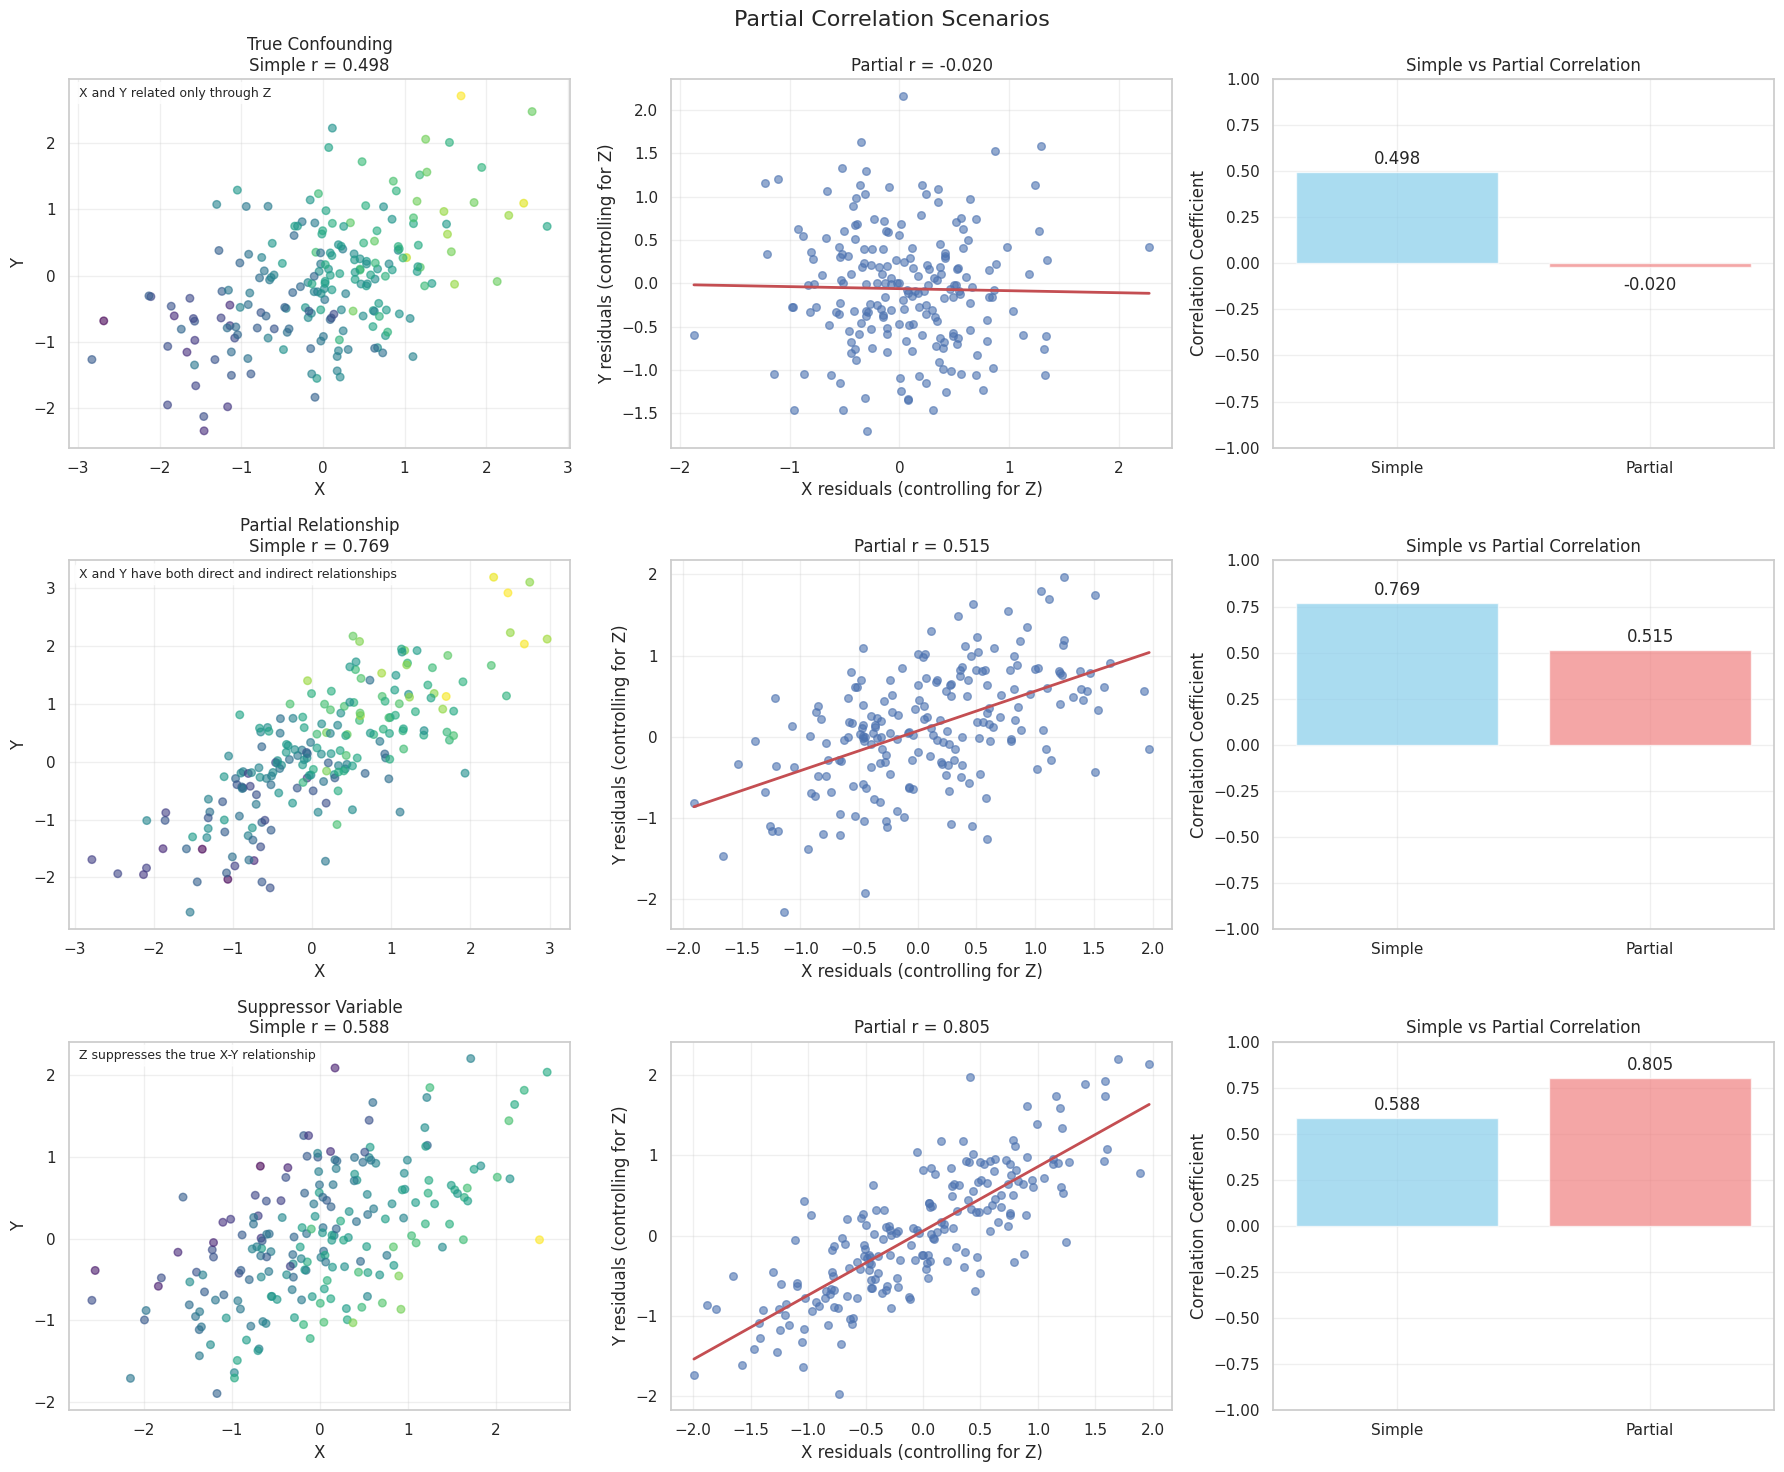

In [ ]:
def demonstrate_partial_correlation_concepts():
    """
    Demonstrate partial correlation concepts with simulated data.
    """
    print(f"\n" + "=" * 70)
    print("PARTIAL CORRELATION CONCEPTS: SIMULATED EXAMPLES")
    print("=" * 70)

    np.random.seed(42)
    n = 200

    # Scenario 1: True confounding
    print(f"\nScenario 1: True Confounding")
    print("-" * 30)

    # Z (confounder) influences both X and Y
    z1 = np.random.normal(0, 1, n)
    x1 = 0.8 * z1 + np.random.normal(0, 0.6, n)  # X depends on Z
    y1 = 0.7 * z1 + np.random.normal(0, 0.7, n)  # Y depends on Z
    # X and Y are NOT directly related, only through Z

    # Scenario 2: Partial relationship
    print(f"Scenario 2: Partial Relationship")
    print("-" * 32)

    # Z influences both X and Y, but X and Y also have direct relationship
    z2 = np.random.normal(0, 1, n)
    x2 = 0.6 * z2 + np.random.normal(0, 0.8, n)  # X depends on Z
    y2 = 0.5 * z2 + 0.4 * x2 + np.random.normal(0, 0.6, n)  # Y depends on both Z and X

    # Scenario 3: Suppressor variable
    print(f"Scenario 3: Suppressor Variable")
    print("-" * 32)

    # Z suppresses the true X-Y relationship
    x3 = np.random.normal(0, 1, n)
    z3 = 0.6 * x3 + np.random.normal(0, 0.8, n)  # Z depends on X
    y3 = 0.8 * x3 - 0.5 * z3 + np.random.normal(0, 0.5, n)  # Y depends positively on X, negatively on Z

    scenarios = [
        ("True Confounding", x1, y1, z1, "X and Y related only through Z"),
        ("Partial Relationship", x2, y2, z2, "X and Y have both direct and indirect relationships"),
        ("Suppressor Variable", x3, y3, z3, "Z suppresses the true X-Y relationship")
    ]

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Partial Correlation Scenarios', fontsize=16)

    for i, (title, x, y, z, description) in enumerate(scenarios):
        # Calculate correlations
        r_xy_simple, _ = pearsonr(x, y)

        # Calculate partial correlation manually
        r_xz, _ = pearsonr(x, z)
        r_yz, _ = pearsonr(y, z)

        numerator = r_xy_simple - (r_xz * r_yz)
        denominator = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))
        r_xy_partial = numerator / denominator if denominator != 0 else np.nan

        # Plot 1: X vs Y scatter plot
        axes[i, 0].scatter(x, y, alpha=0.6, s=30, c=z, cmap='viridis')
        axes[i, 0].set_xlabel('X')
        axes[i, 0].set_ylabel('Y')
        axes[i, 0].set_title(f'{title}\nSimple r = {r_xy_simple:.3f}')
        axes[i, 0].grid(True, alpha=0.3)

        # Plot 2: Partial correlation (residuals)
        # Regress X on Z, get residuals
        slope_xz = np.cov(x, z)[0, 1] / np.var(z)
        x_residuals = x - (slope_xz * z)

        # Regress Y on Z, get residuals
        slope_yz = np.cov(y, z)[0, 1] / np.var(z)
        y_residuals = y - (slope_yz * z)

        axes[i, 1].scatter(x_residuals, y_residuals, alpha=0.6, s=30)
        axes[i, 1].set_xlabel('X residuals (controlling for Z)')
        axes[i, 1].set_ylabel('Y residuals (controlling for Z)')
        axes[i, 1].set_title(f'Partial r = {r_xy_partial:.3f}')
        axes[i, 1].grid(True, alpha=0.3)

        # Add regression line to residuals plot
        if not np.isnan(r_xy_partial):
            z_line = np.polyfit(x_residuals, y_residuals, 1)
            p_line = np.poly1d(z_line)
            x_line = np.linspace(x_residuals.min(), x_residuals.max(), 100)
            axes[i, 1].plot(x_line, p_line(x_line), 'r-', linewidth=2)

        # Plot 3: Comparison bar chart
        correlations = [r_xy_simple, r_xy_partial]
        labels = ['Simple', 'Partial']
        colors = ['skyblue', 'lightcoral']

        bars = axes[i, 2].bar(labels, correlations, color=colors, alpha=0.7)
        axes[i, 2].set_ylabel('Correlation Coefficient')
        axes[i, 2].set_title('Simple vs Partial Correlation')
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].set_ylim(-1, 1)

        # Add value labels on bars
        for bar, corr in zip(bars, correlations):
            height = bar.get_height()
            axes[i, 2].text(bar.get_x() + bar.get_width()/2., height + 0.02 if height >= 0 else height - 0.05,
                           f'{corr:.3f}', ha='center', va='bottom' if height >= 0 else 'top')

        # Add scenario description
        axes[i, 0].text(0.02, 0.98, description, transform=axes[i, 0].transAxes,
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                       verticalalignment='top', fontsize=9)

        print(f"{title}:")
        print(f"  Simple correlation: {r_xy_simple:.3f}")
        print(f"  Partial correlation: {r_xy_partial:.3f}")
        print(f"  Difference: {r_xy_simple - r_xy_partial:.3f}")
        print(f"  Interpretation: {description}")
        print()

    plt.tight_layout()
    plt.show()

# Step 1: Demonstrate partial correlation concepts
print("\n Step 1: Demonstrating partial correlation concepts")
demonstrate_partial_correlation_concepts()

**Summary of Simulated Data Results**

The simulated data perfectly demonstrated three key scenarios:

**Scenario 1: True Confounding**

Simple correlation: r = 0.498 → Partial correlation: r = -0.020

**Explanation:**

X and Y appear moderately correlated. But this correlation is misleading - it's not because X and Y directly influence each other, it's because both X and Y are influenced by Z.

After controlling for Z (Partial correlation r = -0.020):

We remove Z's influence from both X and Y. Now we see the true direct relationship between X and Y, Which is essentially zero (no meaningful direct relationship)

The Key Insight:
The huge difference (0.518) reveals that Z was responsible for almost ALL of the apparent X-Y relationship!

Lesson: X and Y were only related through their mutual dependence on Z

**Scenario 2: Partial Relationship**

Simple correlation: r = 0.769 → Partial correlation: r = 0.515

Result: Relationship weakens but remains substantial

Lesson: X and Y have both direct and indirect relationships through Z

**Scenario 3: Suppressor Variable**

Simple correlation: r = 0.588 → Partial correlation: r = 0.805

Result: The true relationship becomes STRONGER when controlling for Z

Lesson: Z was masking/suppressing the true X-Y relationship

These simulated examples provide the theoretical foundation for understanding what happens with the real penguin data, where species acts as the confounding variable in different ways for different morphological relationships.

# Calculate Partial Correlation

## Main Function: `calculate_partial_correlation()`

In the following code, we calculate partial correlation between two variables while controlling for confounding variables (like species). This tells us what the correlation would be if we removed the influence of the confounding variables.

### Method 1: Regression Residuals Approach
- **What it does**: Uses linear regression to predict each variable from the control variables, then calculates correlation between the leftover residuals
- **Steps**:
  1. Predict X variable using control variables, get residuals
  2. Predict Y variable using control variables, get residuals  
  3. Calculate correlation between the two sets of residuals
- **Why use this**: Most intuitive method that works with any number of control variables

### Method 2: Direct Formula (Single Control Only)
- **What it does**: Uses a mathematical formula to calculate partial correlation directly from simple correlations
- **Formula**: `r_xy.z = (r_xy - r_xz × r_yz) / √[(1-r_xz²)(1-r_yz²)]`
- **Why use this**: Faster computation and serves as a verification that Method 1 is working correctly
- **Limitation**: Only works when controlling for one variable at a time

**Why we use both methods**: Method 1 is the main approach, Method 2 serves as a mathematical check to ensure our calculations are correct. In our code, this method will be skipped as we have more than one control variables (species has 3 categories - Adelie, Chinstrap, Gentoo)

## Helper Function: `create_dummy_variables()`

Converts categorical variables (like species) into numerical dummy variables for use in regression. Uses one-hot encoding with `drop_first=True` to avoid multicollinearity.

## Main Analysis: `analyze_species_effects()`

In the following code, we compare simple correlations (ignoring species) with partial correlations (controlling for species) to see how much species affects the relationships between morphological variables.

### Process:
1. **Create dummy variables** for species (Adelie, Chinstrap, Gentoo)
2. **Calculate simple correlations** between morphological variables (ignoring species)
3. **Calculate partial correlations** between same variables controlling for species
4. **Compare the two** to see how much species was confounding the relationship

### Key Relationships Analyzed:
- Bill length ↔ Body mass
- Flipper length ↔ Body mass  
- Bill length ↔ Bill depth
- Bill length ↔ Flipper length

### Interpretation:
- **Large difference (>0.2)**: Species is a major confounder
- **Moderate difference (0.1-0.2)**: Some species confounding present
- **Small difference (<0.1)**: Relationship exists largely within species

## Comparison Analysis: `perform_within_species_correlations()`

In the following code, we calculate correlations separately for each species to see if relationships hold within individual species or are driven by between-species differences.

### Process:
1. **Split data by species** (Adelie, Chinstrap, Gentoo)
2. **Calculate correlation matrix** for each species separately
3. **Compare correlations across species** to see consistency
4. **Calculate variance and range** of correlations across species

### Key Insights:
- **High variance across species**: Relationship may be driven by species differences
- **Low variance across species**: Relationship is consistent within each species
- **Visual comparison**: Heatmaps show correlation patterns for each species side-by-side

## Overall Goal

The code helps distinguish between:
1. **True within-species relationships**: Correlations that exist within each species
2. **Between-species artifacts**: Correlations that only appear when mixing species together
3. **Species confounding**: How much species membership affects the apparent relationships between morphological variables

#Additional Notes:

**Why only 2 dummy variables for 3 species:**

This is about avoiding the multicollinearity problem in regression.

When you have 3 categories (Adelie, Chinstrap, Gentoo), you only need 2 dummy variables to represent all the information.

With 2 dummy variables:

- species_Chinstrap = [0, 1, 0]  --> 1 if Chinstrap, 0 otherwise
- species_Gentoo    = [0, 0, 1]  --> 1 if Gentoo, 0 otherwise

Now we can identify all 3 species:
- Adelie:     Chinstrap=0, Gentoo=0
- Chinstrap:  Chinstrap=1, Gentoo=0  
- Gentoo:     Chinstrap=0, Gentoo=1

**Why not 3 dummy variables?**

With 3 dummy variables, we have:

species_Adelie + species_Chinstrap + species_Gentoo = 1 (always)

This creates perfect multicollinearity - the three variables are perfectly correlated, which breaks regression calculations.

**The dropped category (Adelie) becomes the reference group. The regression coefficients tell you how Chinstrap and Gentoo differ from Adelie.**

In our code, you see this here:

dummies = pd.get_dummies(data['species'], prefix='species', drop_first=True)


 EXECUTING PARTIAL CORRELATION ANALYSIS

 Step 2: Analyzing species effects on penguin morphology

SPECIES EFFECTS ON PENGUIN MORPHOLOGY CORRELATIONS
Species dummy variables created:
  • species_Chinstrap
  • species_Gentoo

Analyzing relationships with and without species control:

Bill length ↔ Body mass
-----------------------

Calculating partial correlation:
X variable: bill_length_mm
Y variable: body_mass_g
Controlling for: species_Chinstrap, species_Gentoo
Sample size: 333

Method 1: Regression Residuals Approach
---------------------------------------------
Partial correlation (residuals method): 0.5823
P-value: 0.000000

Significance test:
Degrees of freedom: 329
t-statistic: 12.9906
p-value: 0.000000
Effect size: Large

Summary:
Simple correlation:    r = 0.5895 (p = 0.0000)
Partial correlation:   r = 0.5823 (p = 0.0000)
Difference:            Δr = 0.0072
Interpretation: Small species effect - relationship is largely within-species

Flipper length ↔ Body mass
---------------

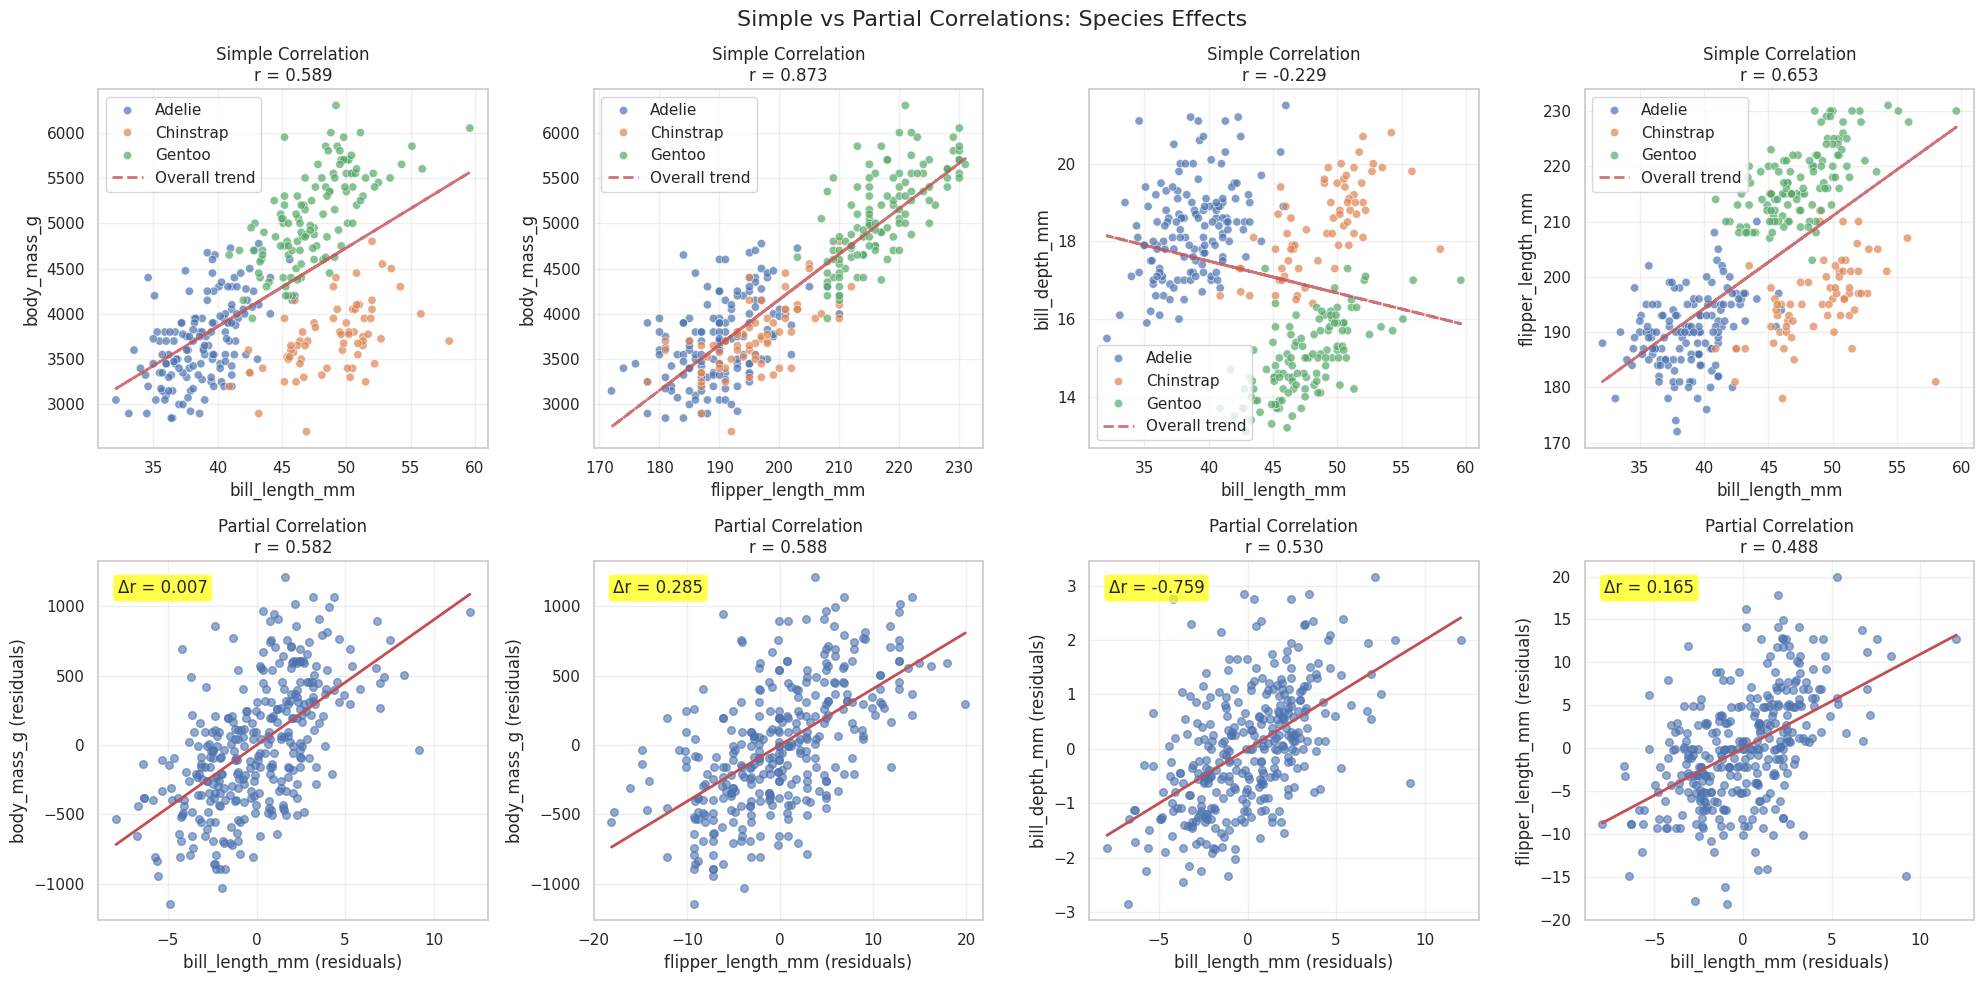


 Step 3: Within-species correlation analysis

WITHIN-SPECIES CORRELATION ANALYSIS
Analyzing correlations within each species:

ADELIE PENGUINS
Sample size: 146

Correlation matrix:
                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm              1.000          0.386              0.332   
bill_depth_mm               0.386          1.000              0.311   
flipper_length_mm           0.332          0.311              1.000   
body_mass_g                 0.544          0.580              0.465   

                   body_mass_g  
bill_length_mm           0.544  
bill_depth_mm            0.580  
flipper_length_mm        0.465  
body_mass_g              1.000  

CHINSTRAP PENGUINS
Sample size: 68

Correlation matrix:
                   bill_length_mm  bill_depth_mm  flipper_length_mm  \
bill_length_mm              1.000          0.654              0.472   
bill_depth_mm               0.654          1.000              0.580   
flipper_length_mm          

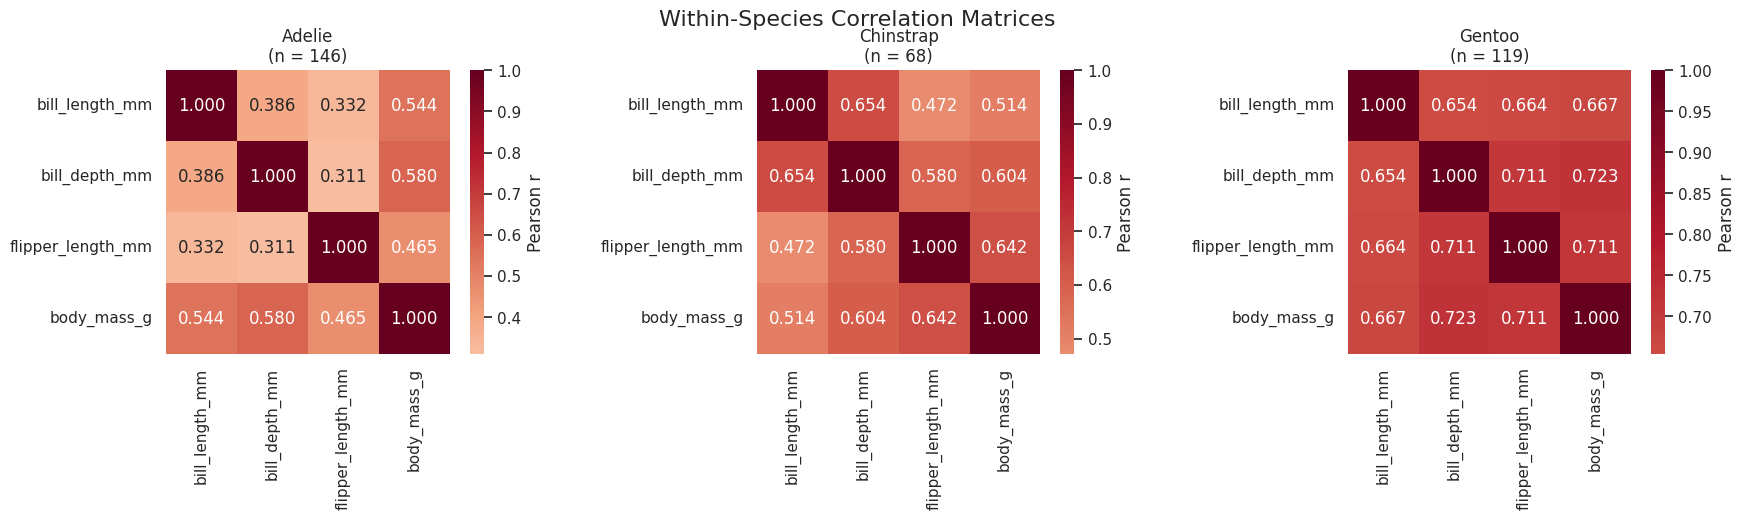


Comparison across species:
------------------------------
                                      Adelie Chinstrap    Gentoo
bill_length_mm ↔ bill_depth_mm      0.385813  0.653536  0.654023
bill_length_mm ↔ flipper_length_mm  0.332274  0.471607  0.664205
bill_length_mm ↔ body_mass_g        0.544276  0.513638   0.66673
bill_depth_mm ↔ flipper_length_mm   0.310897  0.580143  0.710642
bill_depth_mm ↔ body_mass_g         0.580156  0.604498  0.722967
flipper_length_mm ↔ body_mass_g     0.464854  0.641559  0.711305

Variability in correlations across species:
---------------------------------------------
bill_length_mm ↔ bill_depth_mm     : variance = 0.0160, range = 0.268
bill_length_mm ↔ flipper_length_mm : variance = 0.0185, range = 0.332
bill_length_mm ↔ body_mass_g       : variance = 0.0044, range = 0.153
bill_depth_mm ↔ flipper_length_mm  : variance = 0.0277, range = 0.400
bill_depth_mm ↔ body_mass_g        : variance = 0.0039, range = 0.143
flipper_length_mm ↔ body_mass_g    : variance

In [ ]:

def calculate_partial_correlation(data, x_var, y_var, control_vars):
    """
    Calculate partial correlation between two variables controlling for others.

    """
    print(f"\nCalculating partial correlation:")
    print(f"X variable: {x_var}")
    print(f"Y variable: {y_var}")
    print(f"Controlling for: {', '.join(control_vars)}")

    # Get clean data
    all_vars = [x_var, y_var] + control_vars
    clean_data = data[all_vars].dropna()
    n = len(clean_data)

    print(f"Sample size: {n}")

    # Method 1: Using regression residuals (most intuitive)
    print(f"\nMethod 1: Regression Residuals Approach")
    print("-" * 45)

    # Step 1: Regress X on control variables, get residuals
    X_controls = clean_data[control_vars]
    X_target = clean_data[x_var]

    model_x = LinearRegression()
    model_x.fit(X_controls, X_target)
    x_residuals = X_target - model_x.predict(X_controls)

    # Step 2: Regress Y on control variables, get residuals
    Y_target = clean_data[y_var]

    model_y = LinearRegression()
    model_y.fit(X_controls, Y_target)
    y_residuals = Y_target - model_y.predict(X_controls)

    # Step 3: Correlate the residuals
    partial_r_residuals, p_value_residuals = pearsonr(x_residuals, y_residuals)

    print(f"Partial correlation (residuals method): {partial_r_residuals:.4f}")
    print(f"P-value: {p_value_residuals:.6f}")

    # Method 2: Direct formula for single control variable:
    # The direct formula method can only handle one control variable at a time.
    # But in our code we are Controlling for: species_Chinstrap, species_Gentoo
    # So this method will be skipped
    if len(control_vars) == 1:
        print(f"\nMethod 2: Direct Formula (Single Control)")
        print("-" * 45)

        z_var = control_vars[0]

        # Calculate simple correlations
        r_xy, _ = pearsonr(clean_data[x_var], clean_data[y_var])
        r_xz, _ = pearsonr(clean_data[x_var], clean_data[z_var])
        r_yz, _ = pearsonr(clean_data[y_var], clean_data[z_var])

        # Apply partial correlation formula
        numerator = r_xy - (r_xz * r_yz)
        denominator = np.sqrt((1 - r_xz**2) * (1 - r_yz**2))

        if denominator != 0:
            partial_r_formula = numerator / denominator
        else:
            partial_r_formula = np.nan

        print(f"Simple correlations:")
        print(f"  r({x_var}, {y_var}) = {r_xy:.4f}")
        print(f"  r({x_var}, {z_var}) = {r_xz:.4f}")
        print(f"  r({y_var}, {z_var}) = {r_yz:.4f}")
        print(f"Partial correlation (formula): {partial_r_formula:.4f}")

        # Verify methods agree
        diff = abs(partial_r_residuals - partial_r_formula)
        print(f"Difference between methods: {diff:.6f}")

    # Calculate degrees of freedom and significance test
    df = n - len(control_vars) - 2

    # t-statistic for partial correlation
    if abs(partial_r_residuals) < 1:
        t_stat = partial_r_residuals * np.sqrt(df / (1 - partial_r_residuals**2))
        p_value_t = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    else:
        t_stat = np.inf
        p_value_t = 0.0

    print(f"\nSignificance test:")
    print(f"Degrees of freedom: {df}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value_t:.6f}")

    # Effect size interpretation
    if abs(partial_r_residuals) >= 0.5:
        effect_size = "Large"
    elif abs(partial_r_residuals) >= 0.3:
        effect_size = "Medium"
    elif abs(partial_r_residuals) >= 0.1:
        effect_size = "Small"
    else:
        effect_size = "Negligible"

    print(f"Effect size: {effect_size}")

    return {
        'partial_correlation': partial_r_residuals,
        'p_value': p_value_residuals,
        't_statistic': t_stat,
        'degrees_of_freedom': df,
        'effect_size': effect_size,
        'sample_size': n,
        'x_residuals': x_residuals,
        'y_residuals': y_residuals,
        'method_comparison': {
            'residuals_method': partial_r_residuals,
            'formula_method': partial_r_formula if len(control_vars) == 1 else None
        }
    }

# one-hot encoding categorical variables
def create_dummy_variables(data, categorical_var):
    """
    Create dummy variables for categorical variable to use in partial correlation.

    """
    # Create dummy variables (drop first to avoid multicollinearity): one-hot encoding categorical variables
    dummies = pd.get_dummies(data[categorical_var], prefix=categorical_var, drop_first=True)
    return dummies

def analyze_species_effects(data, continuous_vars):
    """
    Analyze how species affects correlations between morphological variables.

    """
    print(f"\n" + "=" * 70)
    print("SPECIES EFFECTS ON PENGUIN MORPHOLOGY CORRELATIONS")
    print("=" * 70)

    # Create species dummy variables
    species_dummies = create_dummy_variables(data, 'species')

    # Combine with continuous variables
    analysis_data = pd.concat([data[continuous_vars], species_dummies], axis=1)
    analysis_data = analysis_data.dropna()

    print(f"Species dummy variables created:")
    for col in species_dummies.columns:
        print(f"  • {col}")

    # Analyze key morphological relationships
    key_relationships = [
        ('bill_length_mm', 'body_mass_g', 'Bill length ↔ Body mass'),
        ('flipper_length_mm', 'body_mass_g', 'Flipper length ↔ Body mass'),
        ('bill_length_mm', 'bill_depth_mm', 'Bill length ↔ Bill depth'),
        ('bill_length_mm', 'flipper_length_mm', 'Bill length ↔ Flipper length')
    ]

    results = {}

    print(f"\nAnalyzing relationships with and without species control:")
    print("=" * 55)

    for x_var, y_var, description in key_relationships:
        print(f"\n{description}")
        print("-" * len(description))


        # Simple correlation (no control) - ensure same sample as partial correlation
        clean_pair_data = analysis_data[[x_var, y_var]].dropna()
        simple_r, simple_p = pearsonr(clean_pair_data[x_var], clean_pair_data[y_var])

        # Partial correlation controlling for species
        control_vars = list(species_dummies.columns)
        partial_result = calculate_partial_correlation(analysis_data, x_var, y_var, control_vars)

        # Calculate the difference
        difference = simple_r - partial_result['partial_correlation']

        print(f"\nSummary:")
        print(f"Simple correlation:    r = {simple_r:.4f} (p = {simple_p:.4f})")
        print(f"Partial correlation:   r = {partial_result['partial_correlation']:.4f} (p = {partial_result['p_value']:.4f})")
        print(f"Difference:            Δr = {difference:.4f}")

        # Interpretation
        if abs(difference) > 0.2:
            interpretation = "Large species effect - species is a major confounder"
        elif abs(difference) > 0.1:
            interpretation = "Moderate species effect - some confounding present"
        else:
            interpretation = "Small species effect - relationship is largely within-species"

        print(f"Interpretation: {interpretation}")

        results[f"{x_var}_{y_var}"] = {
            'description': description,
            'simple_correlation': simple_r,
            'simple_p_value': simple_p,
            'partial_correlation': partial_result['partial_correlation'],
            'partial_p_value': partial_result['p_value'],
            'difference': difference,
            'interpretation': interpretation,
            'x_residuals': partial_result['x_residuals'],
            'y_residuals': partial_result['y_residuals']
        }

    # Create comprehensive visualization
    fig, axes = plt.subplots(2, len(key_relationships), figsize=(5*len(key_relationships), 10))
    fig.suptitle('Simple vs Partial Correlations: Species Effects', fontsize=16)

    for i, (x_var, y_var, description) in enumerate(key_relationships):
        result = results[f"{x_var}_{y_var}"]

        # Top row: Simple correlations with species colored
        sns.scatterplot(data=data, x=x_var, y=y_var, hue='species', ax=axes[0, i], alpha=0.7)

        # Add overall regression line
        x_vals = data[x_var].dropna()
        y_vals = data[y_var].dropna()
        z = np.polyfit(x_vals, y_vals, 1)
        p = np.poly1d(z)
        axes[0, i].plot(x_vals, p(x_vals), "r--", alpha=0.8, linewidth=2, label='Overall trend')

        axes[0, i].set_title(f'Simple Correlation\nr = {result["simple_correlation"]:.3f}')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Bottom row: Partial correlation (residuals plot)
        axes[1, i].scatter(result['x_residuals'], result['y_residuals'], alpha=0.6, s=30)

        # Add regression line for residuals
        z_res = np.polyfit(result['x_residuals'], result['y_residuals'], 1)
        p_res = np.poly1d(z_res)
        x_res_line = np.linspace(result['x_residuals'].min(), result['x_residuals'].max(), 100)
        axes[1, i].plot(x_res_line, p_res(x_res_line), "r-", linewidth=2)

        axes[1, i].set_title(f'Partial Correlation\nr = {result["partial_correlation"]:.3f}')
        axes[1, i].set_xlabel(f'{x_var} (residuals)')
        axes[1, i].set_ylabel(f'{y_var} (residuals)')
        axes[1, i].grid(True, alpha=0.3)

        # Add difference annotation
        diff_text = f'Δr = {result["difference"]:.3f}'
        axes[1, i].text(0.05, 0.95, diff_text, transform=axes[1, i].transAxes,
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                       verticalalignment='top')

    plt.tight_layout()
    plt.show()

    return results

def perform_within_species_correlations(data, continuous_vars):
    """
    Calculate correlations within each species separately.
    """
    print(f"\n" + "=" * 70)
    print("WITHIN-SPECIES CORRELATION ANALYSIS")
    print("=" * 70)

    species_list = data['species'].unique()
    within_species_results = {}

    print(f"Analyzing correlations within each species:")

    for species in species_list:
        print(f"\n{species.upper()} PENGUINS")
        print("=" * (len(species) + 9))

        species_data = data[data['species'] == species][continuous_vars].dropna()
        n_species = len(species_data)

        print(f"Sample size: {n_species}")

        # Calculate correlation matrix for this species
        species_corr = species_data.corr()

        print(f"\nCorrelation matrix:")
        print(species_corr.round(3))

        # Store results
        within_species_results[species] = {
            'correlation_matrix': species_corr,
            'sample_size': n_species,
            'data': species_data
        }

    # Create comparison visualization
    fig, axes = plt.subplots(1, len(species_list), figsize=(6*len(species_list), 5))
    fig.suptitle('Within-Species Correlation Matrices', fontsize=16)

    # Ensure axes is a list for consistent indexing
    if len(species_list) == 1:
        axes = [axes]

    for i, species in enumerate(species_list):
        corr_matrix = within_species_results[species]['correlation_matrix']

        # Create mask for upper triangle
        #mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        sns.heatmap(corr_matrix,
                    #mask=mask,
                    annot=True, cmap='RdBu_r', center=0,
                   square=True, fmt='.3f', ax=axes[i],
                   cbar_kws={'label': 'Pearson r'})

        axes[i].set_title(f'{species}\n(n = {within_species_results[species]["sample_size"]})')

    plt.tight_layout()
    plt.show()

    # Compare correlations across species
    print(f"\nComparison across species:")
    print("-" * 30)

    # Get all unique variable pairs
    var_pairs = []
    for i in range(len(continuous_vars)):
        for j in range(i+1, len(continuous_vars)):
            var_pairs.append((continuous_vars[i], continuous_vars[j]))

    comparison_df = pd.DataFrame(index=[f"{var1} ↔ {var2}" for var1, var2 in var_pairs],
                                columns=species_list)

    for var1, var2 in var_pairs:
        pair_name = f"{var1} ↔ {var2}"
        for species in species_list:
            corr_val = within_species_results[species]['correlation_matrix'].loc[var1, var2]
            comparison_df.loc[pair_name, species] = corr_val

    print(comparison_df.round(3))

    # Calculate variance in correlations across species
    print(f"\nVariability in correlations across species:")
    print("-" * 45)

    for pair_name in comparison_df.index:
        correlations = comparison_df.loc[pair_name].values
        var_corr = np.var(correlations)
        range_corr = np.max(correlations) - np.min(correlations)

        print(f"{pair_name:<35}: variance = {var_corr:.4f}, range = {range_corr:.3f}")

    return within_species_results, comparison_df


# Execute Part 3 Analysis
print("\n EXECUTING PARTIAL CORRELATION ANALYSIS")
print("=" * 50)

# For demonstration, let's use the penguin data
test_data = penguins_clean.head()


# Step 2: Analyze species effects on correlations
print("\n Step 2: Analyzing species effects on penguin morphology")
species_effects = analyze_species_effects(penguins_clean, continuous_vars)

# Step 3: Within-species correlation analysis
print("\n Step 3: Within-species correlation analysis")
within_species_results, species_comparison = perform_within_species_correlations(penguins_clean, continuous_vars)



# Partial Correlation Analysis Results Summary

## Key Findings: Species Effects on Penguin Morphology

### Three Distinct Patterns Emerged

**1. Minimal Species Effect: Bill Length ↔ Body Mass**
- Simple correlation: r = 0.589
- Partial correlation: r = 0.582 (controlling for species)
- **Difference: Δr = 0.007** - Almost no change!
- **Interpretation**: This relationship is genuinely within-species. The correlation we see is not just due to species differences.

**2. Moderate Species Effect: Bill Length ↔ Flipper Length**
- Simple correlation: r = 0.653
- Partial correlation: r = 0.488
- **Difference: Δr = 0.165** - Noticeable reduction
- **Interpretation**: Some of the apparent relationship is due to species differences, but a meaningful within-species relationship remains.

**3. Major Species Effect: Two Dramatic Examples**

**Flipper Length ↔ Body Mass**:
- Simple correlation: r = 0.873 (very strong!)
- Partial correlation: r = 0.588 (moderate)
- **Difference: Δr = 0.285** - Huge reduction!
- **Interpretation**: Much of this "relationship" was actually just reflecting that larger species (Gentoo) have both longer flippers AND heavier bodies.

**Bill Length ↔ Bill Depth** (Most dramatic):
- Simple correlation: r = -0.229 (negative relationship!)
- Partial correlation: r = 0.530 (positive relationship!)
- **Difference: Δr = -0.759** - Complete reversal!
- **Interpretation**: This is a classic "suppressor variable" effect. Between species, longer bills tend to be shallower, but within species, longer bills are actually deeper.

---

## What the Visualizations Show

### Figure 1: Theoretical Examples
The simulated data demonstrates three scenarios:
- **True Confounding**: Simple r = 0.498 → Partial r = -0.020 (relationship disappears)
- **Partial Relationship**: Simple r = 0.769 → Partial r = 0.515 (relationship weakens but persists)
- **Suppressor Variable**: Simple r = 0.588 → Partial r = 0.805 (relationship strengthens)

### Figure 2: Real Penguin Data
The upper panels show clear species clustering - you can see three distinct groups (Adelie, Chinstrap, Gentoo) in each scatter plot. The lower panels (residuals) show the within-species patterns after removing species effects. Notice how the yellow Δr values reveal the magnitude of species confounding.

### Figure 3: Within-Species Patterns
The correlation matrices reveal interesting species differences:
- **Gentoo penguins** show the strongest correlations overall (darker red colors)
- **Adelie penguins** show weaker correlations (lighter colors)
- **Bill length ↔ bill depth** varies dramatically: Adelie (r = 0.386) vs. Chinstrap/Gentoo (r ≈ 0.654)

---

## Biological Insights

### What We Learned About Penguin Morphology

**1. Body Size Relationships Are Real**
- Bill length and body mass correlate strongly within species (r ≈ 0.58)
- This suggests genuine biological scaling - bigger individuals have proportionally longer bills

**2. Species Differences Mask True Relationships**
- The bill length ↔ bill depth relationship was completely obscured by species effects
- Between species: longer bills are shallower (different ecological niches)
- Within species: longer bills are deeper (individual variation in bill robustness)

**3. Some Relationships Are Largely Between-Species**
- Flipper length ↔ body mass drops from r = 0.87 to r = 0.59 when controlling for species
- This suggests much of this relationship reflects species differences rather than individual scaling

### Statistical Significance
All partial correlations were highly significant (p < 0.001), indicating these within-species relationships are robust with our sample size of 333 penguins.

